# **Trustworthy Machine Learning - Uncertainty Homework**


---
Group number: Aldebaran

Bora KARGI

Karahan SARITAŞ

Kıvanç TEZÖREN

**The deadline for this homework is on 28.01.2024.**

**Submission**: Please share your colab notebook with [our email](mailto:stai.there@gmail.com). Make sure you indicate your group number and names.

---
**Structure**: This homework is structured in four topics. We recommend to only start working on each topic after attending the corresponding lecture. The recommended starting dates are indicated in the section headers, but feel free to explore by yourself, too.

For this homework, you also require some external data files that are available [here](https://drive.google.com/drive/folders/1QL0wdfEKyOae-h5ehhuVKOC-EARA9qKF?usp=sharing). These are downloaded automatically in the notebook to the current runtime, but feel free to download them manually to your Google Drive and update the paths for import according throughout the notebook. **Do not use any other external libraries than the ones already defined in the notebook or consult the TML lecture staff first about usage.** You should use a GPU runtime for this exercise (especially for the HuggingFace exercises). **For the theoretical exercises, write down the proof in LaTeX inside a text block.**

If you have any questions about the homework, feel free to drop us a message on Discord or come to the tutorials on Monday at 10:00. The lead tutor for this homework is [Bálint](mailto:balint.mucsanyi@student.uni-tuebingen.de). Have fun!

First, let's install additional libraries we will need in this exercise.

In [ ]:
%pip install -q gdown torchmetrics datasets transformers

The following code downloads all necessary files to the Colab instance. Feel free to replace this with downloading the data manually, mounting your Google Drive, and specifying the paths.

In [ ]:
!pip install gdown==4.6.0 # This fixes the problem as gdown introduces a bug

In [ ]:
!gdown https://drive.google.com/uc?id=1Mox-OzvoqWBZnlaJllIxuvZYyKZRTWU3
!gdown https://drive.google.com/uc?id=1KH_iNpvumQZKZswrPaYl1CM5G9Lxl9xW
!gdown https://drive.google.com/uc?id=15CsHAsA6xqlcr5AdPGTg8-q09ikNZe96
!gdown https://drive.google.com/uc?id=1vP3N4fz8I5TFV1g3qLQkReKKr_O0WfPf
!gdown https://drive.google.com/uc?id=1Q1UqdaGtaBOqRUafJJU38a-pZT4y9Pet
!gdown https://drive.google.com/uc?id=1yStDY0zVLKpya8Pz_EY3y3fR8jbVkbQa
!gdown https://drive.google.com/uc?id=1Zh9y5YC6sh4AR_1TRVQkxVtckK7CFj9D

Downloading...
From: https://drive.google.com/uc?id=1Mox-OzvoqWBZnlaJllIxuvZYyKZRTWU3
To: /content/model1_outputs.csv
100% 50.0k/50.0k [00:00<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KH_iNpvumQZKZswrPaYl1CM5G9Lxl9xW
To: /content/model2_outputs.csv
100% 50.0k/50.0k [00:00<00:00, 93.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=15CsHAsA6xqlcr5AdPGTg8-q09ikNZe96
To: /content/model3_outputs.csv
100% 50.0k/50.0k [00:00<00:00, 86.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vP3N4fz8I5TFV1g3qLQkReKKr_O0WfPf
To: /content/model4_outputs.csv
100% 50.0k/50.0k [00:00<00:00, 68.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Q1UqdaGtaBOqRUafJJU38a-pZT4y9Pet
To: /content/model5_outputs.csv
100% 25.0k/25.0k [00:00<00:00, 50.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yStDY0zVLKpya8Pz_EY3y3fR8jbVkbQa
To: /content/model5_truths_shuffled.csv
100% 25.0k/25.0k [00:00<00:00, 47.4MB/s]
Downloading...
From: https://drive.goog

In [ ]:
PATH = "/content/"

Let's import everything we will need in one go. The cell below also sets the seed for reproducibility.

In [ ]:
import os
import random
import sys
import time
from copy import deepcopy
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lrs
import torchvision.transforms as transforms
from datasets import load_dataset
from sklearn.metrics import roc_auc_score
from torch import Tensor
from torch.distributions import Normal
from torch.nn import Module
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, Dataset, Subset
from torchmetrics import AUROC, Accuracy
from torchvision import datasets, transforms
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoModelForTokenClassification,
    AutoTokenizer,
)

sys.path.insert(0, PATH)
from unc_utils import entropy, get_cifar_loaders


def apply_random_seed(random_seed: int) -> None:
    """Sets seed to ``random_seed`` in random, numpy and torch."""
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


apply_random_seed(2024)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


# **1. Calibration and Proper Scoring (34 points)**
**Recommended start: 11.12.2023**

## 1.1 Proper scoring rules (7 points)
Prove or deny that in a binary classification setup, the negative binary cross-entropy loss is a strictly proper scoring rule.

The binary cross-entropy (BCE) loss is defined as $\mathcal{L}(q, y) = - (y \log(q) + (1-y) \log(1-q))$, where $y \in \{0, 1\}$ is the binary label and $q = \hat{P}(Y=1)$ our predicted probability.

*Hint: Here, our target is predicting the correct $P(Y = 1)$. Predicting the correct $P(L = 1)$ as defined in the lecture would also be a valid target, but you do not need to do that in this exercise.*

We'll start by restricting the domain of the loss function to $D_\mathcal{L} := (0, 1) \times \{0, 1\}$. We will cover the scenarios when $a= 0$ and $a=1$ at the end of our discussion. But the restriction of domain is vital for the following calculations to work without loss of generality [1].

Let $a = P(Y=1)$:

\begin{align}
\mathbb{E}_{P(Y)} - \mathcal{L}(q, Y) &= -P(Y = 0)  \mathcal{L}(q, 0) - P(Y = 1)  \mathcal{L}(q, 1) \\
&= P(Y = 0) \log(1 - q) + P(Y = 1)  \log(q)\\
&= (1-a) \log(1 - q) + a \log(q)\\
\end{align}

We have to show that the ground truth distribution $P$ is one of the maximizers in $Q$. Take the derivative of $\mathbb{E}_{P(Y)} \mathcal{L}(q, Y)$ with respect to $q$ (natural logarithm is assumed, but any other base only introduces a constant factor that wouldn't effect the result):

\begin{align}
\frac{\partial }{\partial q} \mathbb{E}_{P(Y)}\mathcal{L}(q, Y) &= \frac{\partial }{\partial q} ((1-a) \log(1 - q) + a \log(q)) \\
0 &= (\frac{a-1}{1-q} + \frac{a}{q})\\
\frac{a}{q} &= \frac{1-a}{1-q} \\
a - aq &= q - aq \\
a &= q \\
P(Y = 1) &= \hat{P}(Y = 1)
\end{align}

Let's check if the stationary point $q = a$ corresponds to the global maxima with second derivative test:

\begin{align}
\frac{\partial^2 }{\partial q^2} \mathbb{E}_{P(Y)}\mathcal{L}(q, Y) &= \frac{\partial^2 }{\partial q^2} ((1-a) \log(1 - q) + a \log(q))  \\
&= \frac{\partial }{\partial q}(\frac{a-1}{1-q} + \frac{a}{q}) \\
&= \frac{a-1}{(1-q)^2} - \frac{a}{q^2}  \;\;(*)\\
&= \frac{1}{a-1} - \frac{1}{a}  \;\;\;\;\;\;\;\;\;(q = a)
\end{align}


Resulting expression is negative since $0 < a < 1$, which shows that the stationary point $q = a$ is a global maximum. Indeed if we look at the expression $(*)$, we can see that it is always negative, (both $(a-1)$ and $-a$ are negative, denominators are positive) which means that our function is concave in $q$ for $a \in (0, 1)$. Therefore $q = a$ is the global maximum point. Let's analyze the cases when $a = 1$ and $a = 0$:

$$
a = 1 ⇒ \mathbb{E}_{P(Y)} - \mathcal{L}(q, Y) = \log(q) \\
a = 0 ⇒ \mathbb{E}_{P(Y)} - \mathcal{L}(q, Y) = \log(1 - q) $$  

In both of the scenarios, $q = a$ is the global maximum. Therefore we can say that the $q = a$ is the global maximum point for all $a \in [0, 1]$.

To conclude, we showed that $\max_{Q \in \mathcal{Q}} \mathbb{E}_{P(Y)} -\mathcal{L}(Q, Y) = \mathbb{E}_{P(Y)} -\mathcal{L}(q, Y)$ where $\mathcal{Q}$ is a set of probability distributions over the label space. Negative binary-cross entropy loss is a proper scoring rule and $q = P(Y = 1)$ is the unique maximizer of $\mathcal{L}$ in $Q$. Therefore negative binary-cross entropy loss is a strictly proper scoring rule.




[1]: Mucsányi, B., Kirchhof, M., Nguyen, E., Rubinstein, A., & Oh, S. J. (2023). Trustworthy Machine Learning (p. 244). Retrieved from arXiv preprint server (eprint 2310.08215).

## 1.2 Detecting uncalibrated models (27 points)

Santa Claus has prepared some binary classifiers as gifts for the kids. He prepared

* a calibrated and accurate model,
* a calibrated but inaccurate model,
* an uncalibrated but accurate model, and
* an uncalibrated and inaccurate model

and wants to give them to kids depending on how well they behaved this year. Unfortunately, he trips over Rudolf's hooves and the nametags fly off the models. Download and load the files `model1_outputs.csv`, `model2_outputs.csv`, `model3_outputs.csv`, and `model4_outputs.csv`. They contain model predictions $\hat{P}(Y=1)$ in the first column and the ground-truth $Y$ values in the second. Can you help Santa Claus identify which model is which?

In [ ]:
# run once
!pip install black[jupyter] --quiet
from google.colab import drive

drive.mount("/content/drive")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
!black /content/drive/MyDrive/'TML'/'3_UNC.ipynb'

reformatted /content/drive/MyDrive/TML/3_UNC.ipynb

All done! ✨ 🍰 ✨
1 file reformatted.


In [ ]:
model1 = torch.from_numpy(np.loadtxt("model1_outputs.csv", delimiter=","))
model2 = torch.from_numpy(np.loadtxt("model2_outputs.csv", delimiter=","))
model3 = torch.from_numpy(np.loadtxt("model3_outputs.csv", delimiter=","))
model4 = torch.from_numpy(np.loadtxt("model4_outputs.csv", delimiter=","))

#### 1.2.1 Implement uncertainty measures (4 + 4 + 2 + 5 points)

**Implement the following evaluation methods by filling out the code below.**

* Expected calibration error (ECE)
* Reliability diagram
* Negative log-likelihood score (NLL)
* Area under the ROC curve (AUROC)

You may use `matplotlib.pyplot, torch, numpy`, but not `torch.nn` or any other libraries. Feel free to implement any other metric for investigative purposes in later tasks.

*Hint: You may want to write a helper function that you can use for both ECE and the reliability diagram.*

Note: We implemented helper functions with a slightly different set of arguments for ECE score (to cover both of the formulations), reliability diagram, proportion diagram and NLL Loss in order to be able to use them for multiclass classification as well (in the bonus part where we compare proper scoring objective functions on CIFAR-10 dataset).

* ECE score is calculated using the `fraction of positive samples` approach.

In [ ]:
def create_bins(pred_correctness, confs, n_bins=10):
    """
    pred_correctness = a Tensor of correctness of predictions: (n, )
    pred_correctness = 1 --> correct prediction
    pred_correctness = 0 --> wrong prediction

    confs = a Tensor of estimated confidences: (n, )
    """

    # https://pytorch.org/docs/stable/generated/torch.bucketize.html
    bin_width = 1.0 / n_bins
    bins = torch.bucketize(
        confs.contiguous(),
        torch.arange(bin_width, 1 + bin_width, bin_width),
        right=False,
    )

    counts = torch.bincount(bins)  # |B_m|
    counts = torch.cat((counts, torch.zeros(n_bins - len(counts))))
    weights = counts / len(confs)  # |B_m| / n

    mask = counts != 0  # zero mask for |B_m| != 0
    # conf_bm = (1 / |B_m|) * sum over all the confident estimates within that B_m
    # acc_bm  = (1 / |B_m|) * number of correct predictions within that B_m
    conf_bm = torch.zeros(n_bins)
    acc_bm = torch.zeros(n_bins)

    conf_bm.index_add_(0, bins, confs.float())
    acc_bm.index_add_(0, bins, pred_correctness)
    conf_bm[mask] = conf_bm[mask] / counts[mask]
    acc_bm[mask] = acc_bm[mask] / counts[mask]

    return weights, conf_bm, acc_bm

In [ ]:
def ece_score(pred_prob: Tensor, y: Tensor, n_bins: int = 10) -> Tensor:
    """Computes the expected calibration error. (binary case)

    Args:
        pred_prob: Float tensor of shape (n,) containing predicted probabilities.
        y: Float tensor of shape (n,) containing the ground-truth 0 and 1 labels.
        n_bins: Number of (equally sized) bins.

    Returns:
        The ECE in a float tensor of shape (1,).

    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    ece_score = _ece_score(pred_prob, y.float(), n_bins)
    #### >>>> END OF YOUR SOLUTION <<<<

    return ece_score

def _ece_score(confs: Tensor, pred_correctness: Tensor, n_bins: int = 10) -> Tensor:
  """Computes expected calibration error.
  """
  weights, conf_bm, acc_bm = create_bins(pred_correctness, confs, n_bins)
  ece_score = (weights * (acc_bm - conf_bm).abs()).sum()

  return ece_score

In [ ]:
def reliability_diagram(pred_prob: Tensor, y: Tensor, config: int = 0, n_bins: int = 10) -> None:
    """Visualizes a reliability diagram.

    Args:
        pred_prob: Float tensor of shape (n,) containing predicted probabilities.
        y: Float tensor of shape (n,) containing the ground-truth 0 and 1 labels.
        n_bins: Number of (equally sized) bins.
        config: 0 or 1
          If 0: plot (accuracy per bin, confidence per bin)
          If 1: plot (fraction of positive samples per bin, average predicted probability per bin)

    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    if(config == 0):   # confidence-accuracy plot
      preds = pred_prob >= 0.5
      confs = torch.where(preds, pred_prob, 1 - pred_prob)
      pred_correctness = (preds == y) * 1.0
      xlabel = "Confidence"
      ylabel = "Accuracy"
    else:   # average-predicted probability (specific to binary case)
      confs = pred_prob
      pred_correctness = y.float()
      xlabel = "Average predicted probability"
      ylabel = "Fraction of positive samples"

    _reliability_diagram(confs, pred_correctness, n_bins, xlabel, ylabel)
    #### >>>> END OF YOUR SOLUTION <<<<
    plt.gca().set_aspect("equal")


def _reliability_diagram(confs: Tensor, pred_correctness: Tensor, n_bins: int = 10, xlabel: str= "Confidence", ylabel: str = "Accuracy") -> None:
      """Visualizes a reliability diagram.
      """
      weights, conf_bm, acc_bm = create_bins(pred_correctness, confs, n_bins)
      def add_labels(x, y, val):
          for i, v in enumerate(val):
              plt.text(i * 0.1 + 0.02, y[i] + 0.01, int(v))

      plt.bar(
          torch.linspace(0, 1, n_bins + 1)[:-1],
          acc_bm,
          width=0.1,
          align="edge",
          edgecolor="black",
          linewidth=1.2,
          label="Outputs",
      )
      plt.bar(
          torch.linspace(0.05, 1.05, n_bins + 1)[:-1],
          conf_bm - acc_bm,
          width=0.05,
          bottom=acc_bm,
          align="center",
          color="red",
          edgecolor="red",
          alpha=0.3,
          label="Gaps",
      )

      add_labels(torch.linspace(0.05, 1.05, n_bins + 1)[:-1], acc_bm, weights * len(confs))

      plt.plot([0, 1], [0, 1], "k--")
      plt.xticks(np.arange(0, 1.1, 0.1))
      plt.xlabel(xlabel)
      plt.ylabel(ylabel)
      plt.title("Reliability Diagram")
      plt.legend()

In [ ]:
def proportion_diagram(pred_prob: Tensor, y: Tensor, n_bins: int = 10) -> None:
    """Visualizes a proportion diagram.

    Args:
        pred_prob: Float tensor of shape (n,) containing predicted probabilities.
        y: Float tensor of shape (n,) containing the ground-truth 0 and 1 labels.
        n_bins: Number of (equally sized) bins.

    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    _proportion_diagram(pred_prob, y.float(), n_bins)
    #### >>>> END OF YOUR SOLUTION <<<<

    plt.gca().set_aspect("equal")

def _proportion_diagram(confs: Tensor, pred_correctness: Tensor, n_bins: int = 10, config: int = 0) -> None:
  """Visualizes a proportion diagram.
  """
  weights, conf_bm, acc_bm = create_bins(pred_correctness, confs, n_bins)
  indices = torch.linspace(0, 1, n_bins + 1)[:-1]
  bars = weights

  plt.bar(
      indices,
      bars,
      width=0.1,
      align="edge",
      color="green",
      edgecolor="black",
      linewidth=1.2,
      label="Weights",
      alpha=0.3,
  )


  plt.plot([0, 1], [1/n_bins, 1/n_bins], "k--")
  plt.xticks(np.arange(0, 1.1, 0.1))
  if(config == 0): plt.xlabel("Average predicted probability")
  else: plt.xlabel("Confidence")
  plt.ylabel("Proportion")
  plt.title("Proportion Diagram")
  plt.legend()

In [ ]:
def nll_score(pred_prob, y):
  """Computes the negative log-likelihood score.
  Args:
      pred_prob: Float tensor of shape (n,) containing predicted probabilities.
      y: Float tensor of shape (n,) containing the ground-truth 0 and 1 labels.
      n_bins: Number of (equally sized) bins.

  Returns:
      The NLL in a float tensor of shape (1,).

  """
  #### >>>> PUT YOUR SOLUTION HERE <<<<
  preds = pred_prob >= 0.5
  confs = torch.where(preds, pred_prob, 1 - pred_prob)
  pred_correctness = (preds == y) * 1.0

  nll_loss= _nll_loss(confs, pred_correctness)
  print("Negative log-likelihood loss: " + f"{nll_loss :.4f}")
  print("Log probability score: " + f"{-nll_loss :.4f}")
  nll_score = -nll_loss

  #### >>>> END OF YOUR SOLUTION <<<<
  return nll_score

def _nll_loss(confs: Tensor, pred_correctness: Tensor) -> None:
  """Computes the negative log-likelihood loss.
  """
  return -(confs[pred_correctness == 1].log().sum() + (1 - confs[pred_correctness == 0]).log().sum()) / len(pred_correctness)

There are several ways to calculate the AUROC. We'll use a simplified one for the sake of this exercise. First, calculate false-positive and true-positive rates for all possible thresholds (Which are these?). The AUROC is an integral over this curve. You don't need to implement fancy trapezoidal rules nor triangles to approximate this integral, but may simply use rectangles below the curve.

In [ ]:
def auroc_score(pred_prob: Tensor, y: Tensor) -> Tensor:
    """Computes the area under the ROC curve score.

    Args:
        pred_prob: Float tensor of shape (n,) containing predicted probabilities.
        y: Float tensor of shape (n,) containing the ground-truth 0 and 1 labels.

    Returns:
        The AUROC in a float tensor of shape (1,).

    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    thresholds = torch.unique(pred_prob).sort()[0]

    # compute true positive rate and false positive rate for each threshold
    # true positive rate: proportion of true positives among all positives
    # false positive rate: proportion of false positives among all negatives
    tpr = torch.zeros(len(thresholds))
    fpr = torch.zeros(len(thresholds))

    for i, c_i in enumerate(thresholds):
        # compute true positives and false positives for threshold c_i
        tp = ((pred_prob >= c_i) & (y == 1)).sum()
        fp = ((pred_prob >= c_i) & (y == 0)).sum()
        tn = ((pred_prob < c_i) & (y == 0)).sum()
        fn = ((pred_prob < c_i) & (y == 1)).sum()

        # compute true positive rate and false positive rate
        tpr[i], fpr[i] = tp / (tp + fn), fp / (fp + tn)

    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    fpr, _ = fpr.sort()
    tpr, _ = tpr.sort()
    auroc_score = 0
    for i in range(len(thresholds) - 1):
        auroc_score += (fpr[i + 1] - fpr[i]) * tpr[i + 1]
    # add the very first and the last bin
    auroc_score += fpr[0] * tpr[0] / 2
    auroc_score += (1 - fpr[-1]) * (1 + tpr[-1]) / 2

    #### >>>> END OF YOUR SOLUTION <<<<

    return auroc_score

#### 1.2.2 Interpret the results (4 points)
Apply your scores implemented above to the model results and **argue which model is which and why.**
For uncalibrated models, also answer **whether they are overconfident, underconfident, or a mixture**.

If you could not implement the models in 1.2.1, you may use existing libraries. Feel free to add additional metrics of existing libraries if you find them useful for finding out which model is which (or implement them yourself if you feel adventurous).

*Hint: Be critical of your metrics! Each metric only evaluates a certain property of the model. Some metrics might even be misleading due to other properties of the model that are not easily visible.*

Model1 ECE: 0.21446897089481354
Negative log-likelihood loss: 0.7216
Log probability score: -0.7216
Model1 NLL: -0.7215890474531186


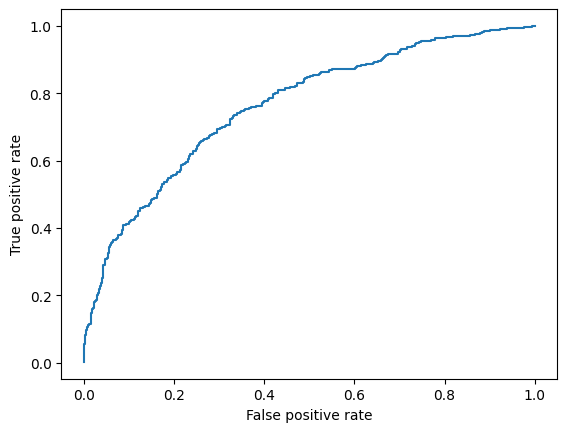

Model1 AUROC: 0.7623587250709534


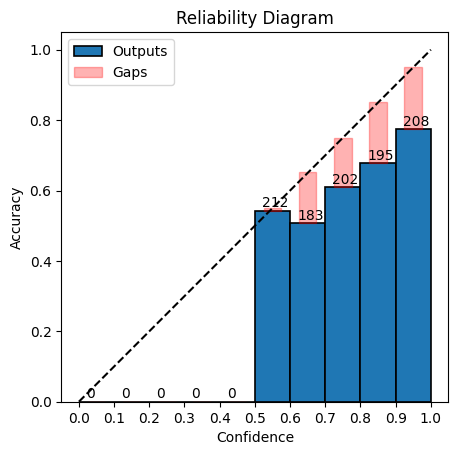

In [ ]:
print(f"Model1 ECE: {ece_score(model1[:,0], model1[:,1]).item()}")
print(f"Model1 NLL: {nll_score(model1[:,0], model1[:,1]).item()}")
print(f"Model1 AUROC: {auroc_score(model1[:,0], model1[:,1]).item()}")
reliability_diagram(model1[:, 0], model1[:, 1])
plt.show()

Model1 Accuracy: 0.6240
Model1 Average confidence: 0.7510


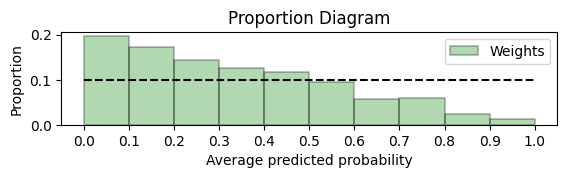

In [ ]:
proportion_diagram(model1[:, 0], model1[:, 1])
accuracy = (((model1[:, 0] >= 0.5) == model1[:, 1]) * 1.0).mean()
print(f"Model1 Accuracy: {accuracy:.4f}")
preds = model1[:, 0] >= 0.5
confs = torch.where(preds, model1[:, 0], 1 - model1[:, 0]).mean()
print(f"Model1 Average confidence: {confs:.4f}")

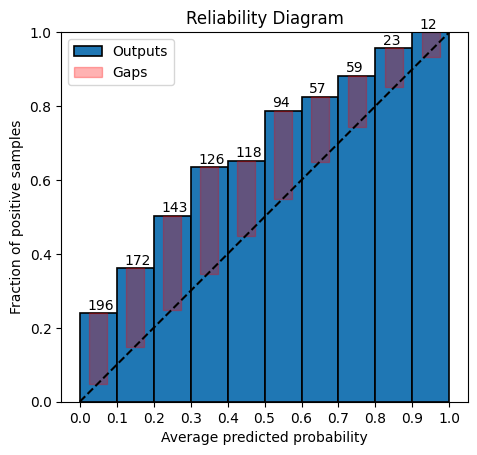

In [ ]:
reliability_diagram(model1[:, 0], model1[:, 1], config=1)

Model2 ECE: 0.029783645644783974
Negative log-likelihood loss: 0.5882
Log probability score: -0.5882
Model2 NLL: -0.5881873570559447


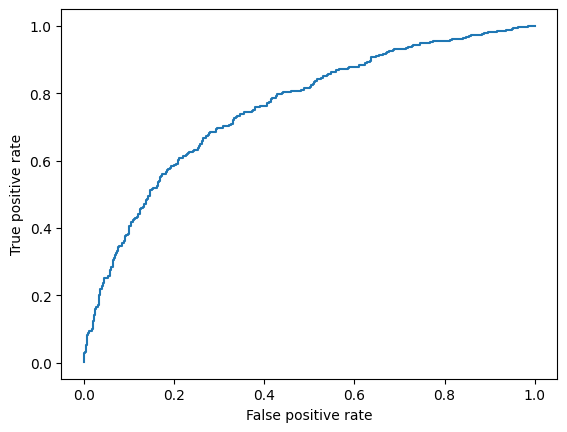

Model2 AUROC: 0.7577134966850281


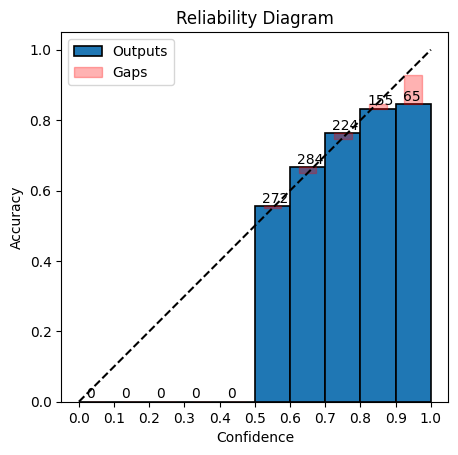

In [ ]:
print(f"Model2 ECE: {ece_score(model2[:,0], model2[:,1]).item()}")
print(f"Model2 NLL: {nll_score(model2[:,0], model2[:,1]).item()}")
print(f"Model2 AUROC: {auroc_score(model2[:,0], model2[:,1]).item()}")
reliability_diagram(model2[:, 0], model2[:, 1])
plt.show()

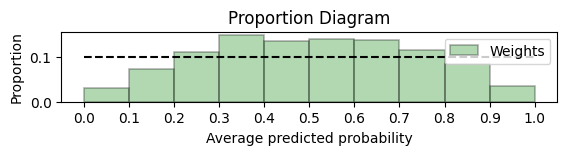

In [ ]:
proportion_diagram(model2[:, 0], model2[:, 1])

Model2 Accuracy: 0.6950
Model2 Average confidence: 0.6927


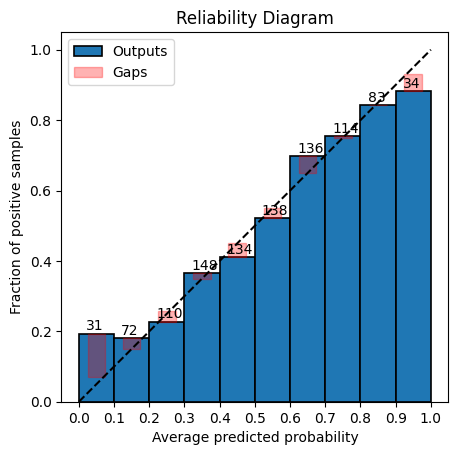

In [ ]:
reliability_diagram(model2[:, 0], model2[:, 1], config=1)
accuracy = (((model2[:, 0] >= 0.5) == model2[:, 1]) * 1.0).mean()
print(f"Model2 Accuracy: {accuracy:.4f}")
preds = model2[:, 0] >= 0.5
confs = torch.where(preds, model2[:, 0], 1 - model2[:, 0]).mean()
print(f"Model2 Average confidence: {confs:.4f}")

Model3 ECE: 0.0077701471745967865
Negative log-likelihood loss: 0.0669
Log probability score: -0.0669
Model3 NLL: -0.06686655541334767


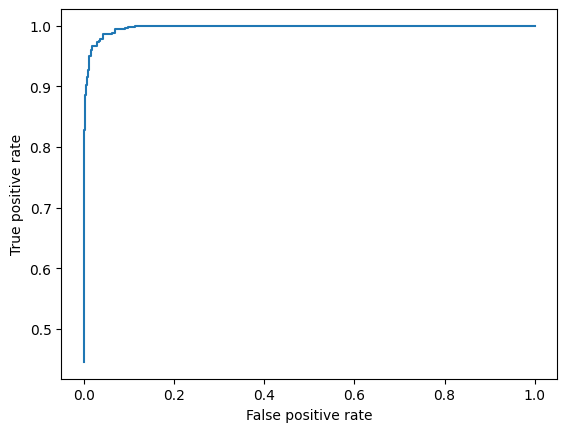

Model3 AUROC: 0.9972800612449646


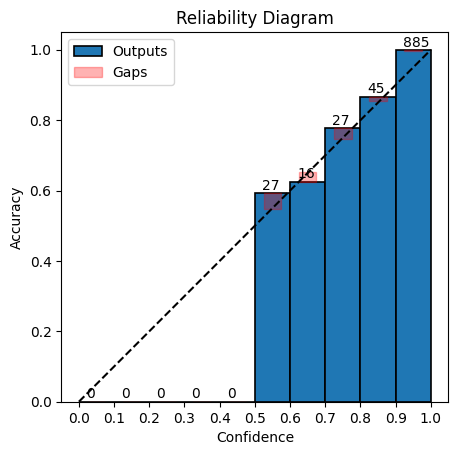

In [ ]:
print(f"Model3 ECE: {ece_score(model3[:,0], model3[:,1]).item()}")
print(f"Model3 NLL: {nll_score(model3[:,0], model3[:,1]).item()}")
print(f"Model3 AUROC: {auroc_score(model3[:,0], model3[:,1]).item()}")
reliability_diagram(model3[:, 0], model3[:, 1])
plt.show()

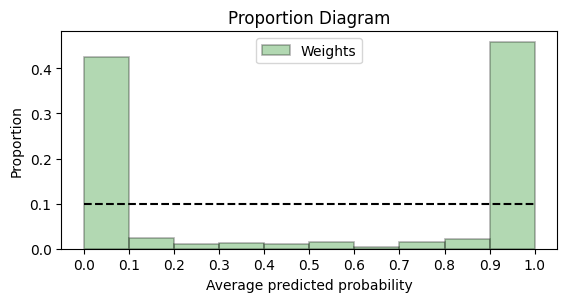

In [ ]:
proportion_diagram(model3[:, 0], model3[:, 1])

Model3 Accuracy: 0.9700
Model3 Average confidence: 0.9656


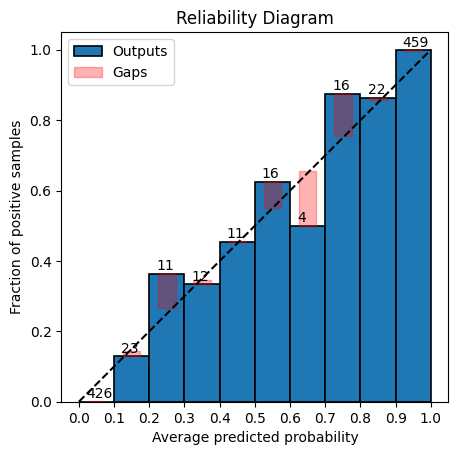

In [ ]:
reliability_diagram(model3[:, 0], model3[:, 1], config=1)
accuracy = (((model3[:, 0] >= 0.5) == model3[:, 1]) * 1.0).mean()
print(f"Model3 Accuracy: {accuracy:.4f}")
preds = model3[:, 0] >= 0.5
confs = torch.where(preds, model3[:, 0], 1 - model3[:, 0]).mean()
print(f"Model3 Average confidence: {confs:.4f}")

Model4 ECE: 0.15549054741859436
Negative log-likelihood loss: 0.4640
Log probability score: -0.4640
Model4 NLL: -0.46399156110535317


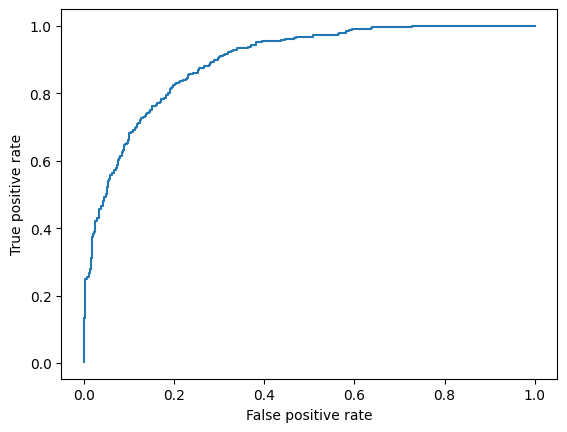

Model4 AUROC: 0.8960691690444946


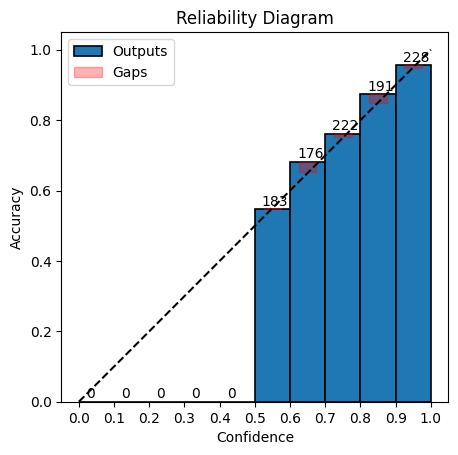

In [ ]:
print(f"Model4 ECE: {ece_score(model4[:,0], model4[:,1]).item()}")
print(f"Model4 NLL: {nll_score(model4[:,0], model4[:,1]).item()}")
print(f"Model4 AUROC: {auroc_score(model4[:,0], model4[:,1]).item()}")
reliability_diagram(model4[:, 0], model4[:, 1])
plt.show()

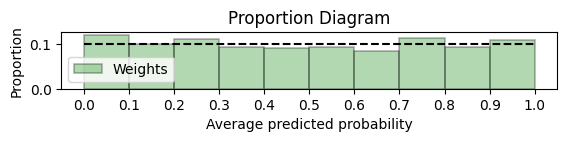

In [ ]:
proportion_diagram(model4[:, 0], model4[:, 1])

Model4 Accuracy: 0.7740
Model4 Average confidence: 0.7613


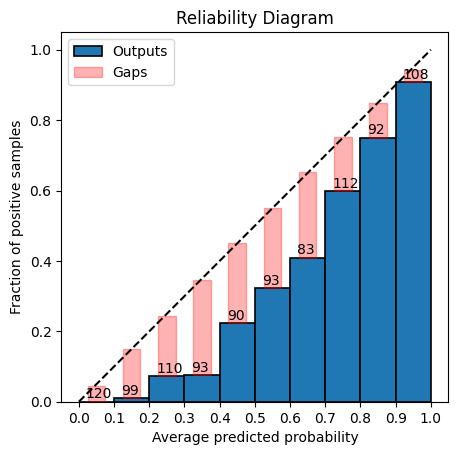

In [ ]:
reliability_diagram(model4[:, 0], model4[:, 1], config = 1)
accuracy = (((model4[:, 0] >= 0.5) == model4[:, 1]) * 1.0).mean()
print(f"Model4 Accuracy: {accuracy:.4f}")
preds = model4[:, 0] >= 0.5
confs = torch.where(preds, model4[:, 0], 1 - model4[:, 0]).mean()
print(f"Model4 Average confidence: {confs:.4f}")

In total, following metrics are implemented to analyze the models:
* Expected calibration error (ECE)
* Reliability diagram
* Negative log-likelihood score (NLL)
  * Here, negative log-likelihood **loss** is a positive value $w$, where our aim is to minimize it. Log probability **score** is a negative value $-w$, where our aim is to maximize it. Both of them are reported in the results.
* Area under the ROC curve (AUROC)
* Proportion Diagram

| Model  | ECE   | Accuracy | AUROC | NLL Loss |
|--------|------------|----------|-------|------|
| Model 1| 0.214      | 0.62     | 0.76  | 0.72 |
| Model 2| 0.029     | 0.69     | 0.75  | 0.58 |
| Model 3| **0.008**      | **0.97**     | **0.99**  | **0.06** |
| Model 4| 0.155      | 0.77     | 0.89 | 0.46 |

As can be seen from the table, model #3 outperforms the other models in terms of both accuracy and ECE score. Model #4 achieves the second highest accuracy and AUROC score. Therefore it is reasonable to suggest that accurate models are model #3 (calibrated) and model #4 (uncalibrated). Model #1 achieves, by far the highest ECE score and NLL Loss. So it would make sense to call model #1 to be uncalibrated and inaccurate; whereas model #2 to be calibrated and inaccurate.

**Model 3 is calibrated and accurate** because it achieves both the highest accuracy and the highest AUROC score (therefore it's unlikely that the model takes advantage of class imbalance to achieve high accuracy). It has the lowest ECE score and it can be seen from the proportion diagram that the model is extremely likely to predict probabilities either less than 0.1 or higher than 0.9, showing high confidence in its predictions.

**Model 4 is uncalibrated but accurate** because it is the second most accurate model among all the models. However, it can be seen from the proportion diagram that it does not produce sufficiently confident probability estimates for the samples. It is a **mixture of both** due to the following reasoning: For negative samples, our model typically assigns low confidence values. For instance, with an average probability range of 0.4-0.5, we anticipate the ratio of positive samples to be approximately 0.4-0.5 across all examples. However, the actual count of positive samples is lower than expected. Conversely, for positive samples, our model tends to assign high confidence values, leading to predictions of a greater number of positive samples than there actually are.


**Model 2 is calibrated but inaccurate** because although it achieves lower ECE score than that of model #1 (other inaccurate model), their accuracy and AUROC scores are somewhat similar - which makes it reasonable to classify both of them as inaccurate.

**Model 1 is uncalibrated and inaccurate** because it achieves a lower accuracy, lower AUROC and high NLL loss along with the highest ECE score among all the models. **It is overconfident** because the average confidence $(0.7510)$ exceeds the accuracy $(0.6240)$. Achieved accuracy for each confidence bin is below the diagonal.

**Bonus question (2 points)**: Why does the reliability diagram of model 3 look so weird?

**Answer**: The reliability diagram for Model 3, depicting the fraction of positive samples per bin and the average predicted probability per bin, exhibits peculiar fluctuations with occasional ups and downs. However, despite these visual anomalies, the ECE score for Model 3 appears to be the lowest among all the models evaluated.

At first glance, there may appear to be a discrepancy between the reliability diagram and the ECE score. However, upon closer examination and the inclusion of the number of samples information for each bin, the proportion diagram reveals that the model tends to make a substantial number of highly confident predictions. For instance, there are $426$ points with predicted probabilities less than $0.1$ and $459$ points with predicted probabilities higher than $0.9$. The bins in between contain fewer samples, consequently contributing less to the overall ECE score. Furthermore, due to the limited number of samples, the bins in between become highly sensitive to incorrect predictions, leading to noticeable deviations from the diagonal in the reliability diagram.


#### 1.2.3 Cheating the ECE (5 points)

Santa now has his gifts sorted. There's another kid that deserves a present, but Santa's last model, `model5_outputs.csv`, has a very bad looking ECE. Santa is concerned that the gift will be rejected. His ground-truth $y$ values were unfortunately randomly shuffled (`model5_truths_shuffled.csv`) when he tripped, so he can't retrain and improve the model in a scientifically meaningful way. Thus, he decides to cheat (Yikes!) to make the score look better on paper than the model is.

**Write a function that adapts the predicted probabilities to increase the ECE score of the model** (with `n_bins = 10`). To make sure that you don't cheat while cheating, `model5_truths_shuffled.csv` only contains a randomly permuted variant of the ground-truth values. The current ECE of model5 on the real ground-truth values is 0.25. You get full points if you manage to decrease it below 0.2 by any means.

*Hint: Test your function by applying it to models 1-4 and calculating their ECE.*

In [ ]:
model5 = torch.from_numpy(np.loadtxt("model5_outputs.csv", delimiter=","))
model5_shuffled_y = torch.from_numpy(
    np.loadtxt("model5_truths_shuffled.csv", delimiter=",")
)

## Approach

While the ECE boasts several favorable characteristics, it falls short as a valid scoring rule. We calculate the ECE score based on `(average predicted probability, fraction of positive samples` plot. We can minimize the ECE score by setting $c = \frac{N_p}{N_p + N_n}$ where $N_p$ is the number of positive labels, and $N_n$ is the number of negative labels in the dataset.

In [ ]:
def increase_ece(pred_prob: Tensor, shuffled_y: Tensor):
    """Adapts the predicted probabilities to make them look better under the ECE measure.

    Args:
        pred_prob: Float tensor of shape (n,) containing predicted probabilities.
        y: Float tensor of shape (n,) containing randomly permuted 0 and 1 labels.

    Returns:
        A float tensor of the same shape as pred_prob with adapted probabilities.

    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    zeros = (shuffled_y == 0).sum()
    fraction_of_positives = 1 - (zeros/len(shuffled_y))

    new_pred_prob = torch.ones(len(shuffled_y)) * fraction_of_positives

    #### >>>> END OF YOUR SOLUTION <<<<
    return new_pred_prob


# A small verification for yourselves on data where you know the GT y:
old_ece = ece_score(model4[:, 0], model4[:, 1]).item()
new_ece = ece_score(
    increase_ece(model4[:, 0], model4[torch.randperm(model4.shape[0]), 1]), model4[:, 1]
).item()
print(f"Model 4: Old ECE was {old_ece} and new ECE is {new_ece}")

Model 4: Old ECE was 0.15549054741859436 and new ECE is 3.2186508178710938e-06


#### 1.2.4 Cheat prevention (3 points)
If your model behaves in any way like Santa, it can abuse the above adversarial techniques to decrease the ECE by returning probabilities that aren't its true beliefs. **Argue why any cheat like this is impossible for NLL (unless the model truly becomes better).**

In contrast to ECE score, log-likelihood score (which is the negative of NLL loss) is a *strictly proper scoring rule*. It is proven (2) that the log-likelihood score has only one stationary point, and it is concave. It takes its maximum value only when the confidence corresponds to the true probability (or accuracy). Since the function is concave, it is also reasonable to suggest that it is only possible to achieve a higher score (lower NLL loss) when the model truly becomes better, in other words, predicted probability gets closed to the true probability from either sides (absolute value of the difference between predicted probability and true probability decreases).



[2]: Mucsányi, B., Kirchhof, M., Nguyen, E., Rubinstein, A., & Oh, S. J. (2023). Trustworthy Machine Learning (p. 245). Retrieved from arXiv preprint server (eprint 2310.08215).

**Bonus question (4 points)**: Comparing scoring rules. In the lecture, we have seen a few strictly proper scoring rules for predictive uncertainty, and also some lower bounds thereof. Below, we provide some boilerplate for downloading the CIFAR-10 dataset.

Try out any two proper scoring rules from the lecture as training objectives. Make sure you provide a fair comparison: some scoring rules might require different hyperparameters than others. Do you get different accuracies and calibration? Use the evaluation methods you have implemented above to support your findings.

**Answer**: We decided to compare NLL Loss (based on log-probability score) and the loss defined by multi-class Brier score [3]. Both of the scoring rules, log-probability and Brier are proven to be strictly proper scoring rules in the book.

$$
\mathcal{L}_{\text{NLL}} = -\frac{1}{N_{\text{test}}} ∑^{N_{\text{test}}}_{i=1} \log{f_{y_i} (x_i)}\\
\mathcal{L}_{\text{Brier}} = \frac{1}{N_{\text{test}}}  ∑^{N_{\text{test}}}_{i=1} \left[ (1 - f_{y_i} (x_i))^2  + ∑_{k \neq y_i} f_k(x_i)^2 \right]
$$


[3]: Mucsányi, B., Kirchhof, M., Nguyen, E., Rubinstein, A., & Oh, S. J. (2023). Trustworthy Machine Learning (p. 253). Retrieved from arXiv preprint server (eprint 2310.08215).

Disclaimer: Implementation below is inspired by the notebooks shared in the book.

In [ ]:
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 10

In [ ]:

train_loader, val_loader, test_loader = get_cifar_loaders()

100%|██████████| 170498071/170498071 [00:01<00:00, 88403935.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class SimpleNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=30, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=30, out_channels=50, kernel_size=3)
        self.fc = nn.Linear(in_features=50 * 4 * 4, out_features=10)

    def forward(self, x: Tensor) -> Tensor:
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = F.softmax(x, dim=-1)

        return x

In [ ]:
def train_single_loop(
    model: SimpleNet,
    device: str,
    train_loader: DataLoader,
    optimizer: Adam,
    loss_fn: Callable,
) -> None:
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()


def val(
    model: SimpleNet,
    device: str,
    val_loader: DataLoader,
    epoch: int,
    loss_fn: Callable,
) -> None:
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            pred = output.argmax(dim=-1)

            val_loss += loss_fn(output, target).item()
            correct += (pred == target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / len(val_loader.dataset)

    print(
        f"[Epoch {epoch:2d}]: Average loss: {val_loss:.4f}, "
        f"Accuracy: {correct}/{len(val_loader.dataset)} ({val_accuracy:.0f}%)"
    )


def train(
    model: SimpleNet,
    device: str,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: Adam,
    loss_fn: Callable,
    scheduler: Optional[MultiStepLR] = None,
    num_epochs: int = 10,
) -> None:
    model = model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_single_loop(model, device, train_loader, optimizer, loss_fn)

        model.eval()
        val(model, device, val_loader, epoch, loss_fn)

        if scheduler is not None:
            scheduler.step()

    print("Done!")

In [ ]:
def NLLLoss(pred_prob, y):
    """Computes the Negative Log-Likelihood Loss.
    Args:
        pred_prob: Float tensor of shape (n, c) containing predicted probabilities.
        y: Long tensor of shape (n,) containing the ground-truth class labels.

    Returns:
        The NLL loss in a float tensor of shape (1,).
    """
    assert pred_prob.shape[0] == y.shape[0], "Input shapes do not match"
    # F.nll_loss expects the log probabilities
    return F.nll_loss(pred_prob.log(), y)


def multiclass_brier_loss(pred_prob, y):
    """Computes the Multiclass Brier Loss.
    Args:
        pred_prob: Float tensor of shape (n, num_classes) containing predicted probabilities.
        y: Long tensor of shape (n,) containing the ground-truth class labels.

    Returns:
        The Multiclass Brier Loss in a float tensor of shape (1,).
    """
    # Ensure the input tensors have the same shape
    assert pred_prob.shape[0] == y.shape[0], "Input shapes do not match"

    y_one_hot = F.one_hot(y, num_classes=pred_prob.shape[1]).float()
    brier_loss = (pred_prob - y_one_hot).square().sum(dim=1).mean()

    return brier_loss

In [ ]:
def brier_score(test_confs: Tensor, test_correctness: Tensor) -> Tensor:
    brier_score = -(test_confs - test_correctness).square().mean()

    return brier_score

In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_nll = SimpleNet().to(device)
optimizer = optim.Adam(model_nll.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
scheduler = MultiStepLR(optimizer, milestones=[7], gamma=0.5)

train(model_nll, device, train_loader, val_loader, optimizer, NLLLoss, scheduler, num_epochs=EPOCHS)

100%|██████████| 704/704 [00:28<00:00, 24.62it/s]


[Epoch  1]: Average loss: 1.4234, Accuracy: 2445/5000 (49%)


100%|██████████| 704/704 [00:14<00:00, 48.44it/s]


[Epoch  2]: Average loss: 1.2290, Accuracy: 2812/5000 (56%)


100%|██████████| 704/704 [00:14<00:00, 47.77it/s]


[Epoch  3]: Average loss: 1.0726, Accuracy: 3138/5000 (63%)


100%|██████████| 704/704 [00:13<00:00, 51.06it/s]


[Epoch  4]: Average loss: 1.0532, Accuracy: 3133/5000 (63%)


100%|██████████| 704/704 [00:17<00:00, 40.00it/s]


[Epoch  5]: Average loss: 1.0041, Accuracy: 3254/5000 (65%)


100%|██████████| 704/704 [00:15<00:00, 44.61it/s]


[Epoch  6]: Average loss: 0.9938, Accuracy: 3253/5000 (65%)


100%|██████████| 704/704 [00:15<00:00, 45.38it/s]


[Epoch  7]: Average loss: 0.9746, Accuracy: 3337/5000 (67%)


100%|██████████| 704/704 [00:15<00:00, 46.48it/s]


[Epoch  8]: Average loss: 0.9422, Accuracy: 3389/5000 (68%)


100%|██████████| 704/704 [00:15<00:00, 44.16it/s]


[Epoch  9]: Average loss: 0.9302, Accuracy: 3411/5000 (68%)


100%|██████████| 704/704 [00:14<00:00, 49.26it/s]


[Epoch 10]: Average loss: 0.9185, Accuracy: 3450/5000 (69%)
Done!


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_brier = SimpleNet().to(device)
optimizer = optim.Adam(model_brier.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
scheduler = MultiStepLR(optimizer, milestones=[7], gamma=0.5)

train(model_brier, device, train_loader, val_loader, optimizer, multiclass_brier_loss, scheduler, num_epochs=EPOCHS)

100%|██████████| 704/704 [00:15<00:00, 45.61it/s]


[Epoch  1]: Average loss: 0.6555, Accuracy: 2436/5000 (49%)


100%|██████████| 704/704 [00:16<00:00, 43.89it/s]


[Epoch  2]: Average loss: 0.5473, Accuracy: 2931/5000 (59%)


100%|██████████| 704/704 [00:16<00:00, 43.36it/s]


[Epoch  3]: Average loss: 0.5199, Accuracy: 3025/5000 (60%)


100%|██████████| 704/704 [00:16<00:00, 41.58it/s]


[Epoch  4]: Average loss: 0.4945, Accuracy: 3166/5000 (63%)


100%|██████████| 704/704 [00:13<00:00, 51.38it/s]


[Epoch  5]: Average loss: 0.5091, Accuracy: 3129/5000 (63%)


100%|██████████| 704/704 [00:14<00:00, 47.17it/s]


[Epoch  6]: Average loss: 0.4796, Accuracy: 3223/5000 (64%)


100%|██████████| 704/704 [00:15<00:00, 46.48it/s]


[Epoch  7]: Average loss: 0.4730, Accuracy: 3263/5000 (65%)


100%|██████████| 704/704 [00:13<00:00, 51.69it/s]


[Epoch  8]: Average loss: 0.4562, Accuracy: 3308/5000 (66%)


100%|██████████| 704/704 [00:18<00:00, 38.22it/s]


[Epoch  9]: Average loss: 0.4515, Accuracy: 3361/5000 (67%)


100%|██████████| 704/704 [00:16<00:00, 42.16it/s]


[Epoch 10]: Average loss: 0.4495, Accuracy: 3357/5000 (67%)
Done!


In [ ]:
def evaluate_predictive_uncertainty(model, test_loader):
  model.eval()

  test_confs =  torch.zeros(len(test_loader.dataset))
  test_correctness = torch.zeros(len(test_loader.dataset))
  batch = test_loader.batch_size
  with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
      data, target = data.to(device), target.to(device)
      pred_prob = model(data)

      confidence, preds = pred_prob.max(dim=-1)
      pred_correctness = (preds == target) * 1.0

      test_confs[i * batch: (i+1) * batch] = confidence
      test_correctness[i * batch: (i+1) * batch] = pred_correctness

  _proportion_diagram(test_confs, test_correctness, n_bins=10, config=1)
  plt.show()
  _reliability_diagram(test_confs, test_correctness, n_bins=10)
  plt.show()
  print(f"ECE score: {_ece_score(test_confs, test_correctness, n_bins=10).item():.4f}")
  print(f"Log-probability Score: {-_nll_loss(test_confs, test_correctness).item():.4f}")
  print(f"Brier score: {brier_score(test_confs, test_correctness).item():.4f}")

In [ ]:
def brier_score(test_confs: Tensor, test_correctness: Tensor) -> Tensor:
    brier_score = -(test_confs - test_correctness).square().mean()
    return brier_score

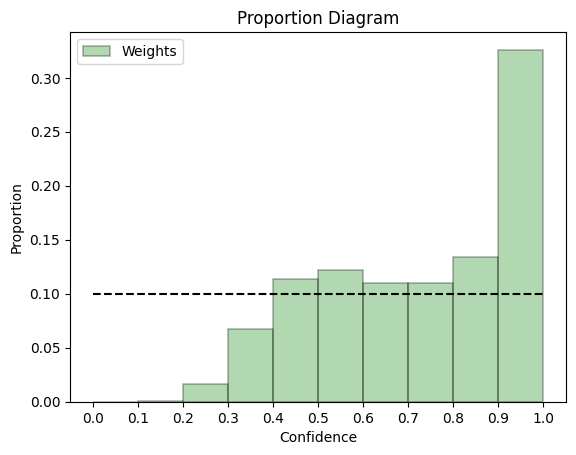

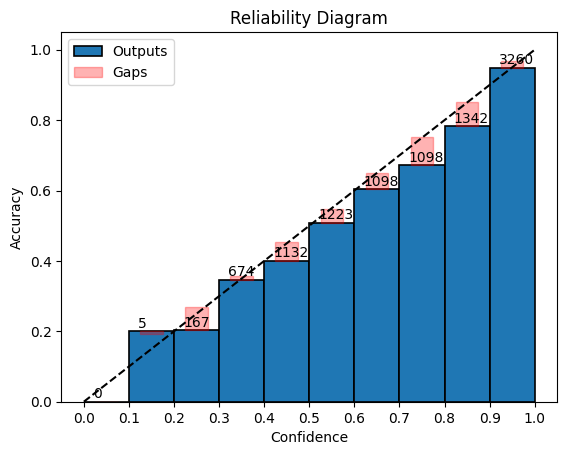

ECE score: 0.0414
Log-probability Score: -0.4925
Brier score: -0.1660


In [ ]:
evaluate_predictive_uncertainty(model_nll, test_loader)

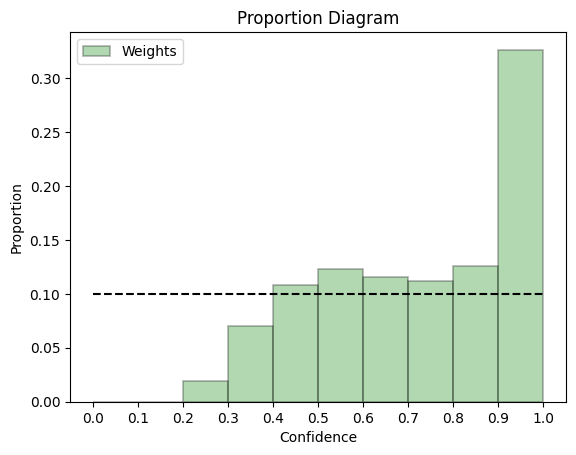

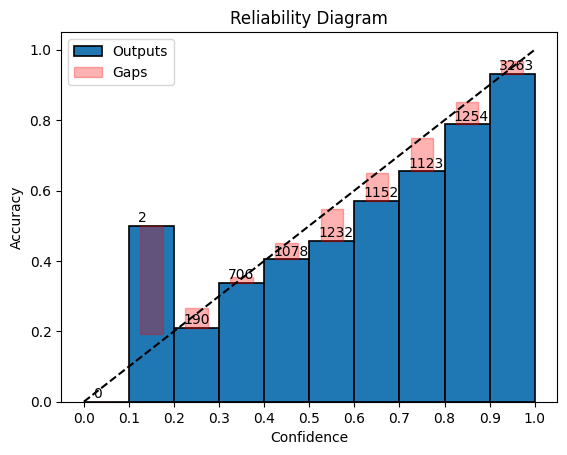

ECE score: 0.0578
Log-probability Score: -0.5164
Brier score: -0.1735


In [ ]:
evaluate_predictive_uncertainty(model_brier, test_loader)

## Analysis
Both the model trained with NLL loss and the model trained with Multiclass Brier Loss achieved an accuracy around $67\%$, experiencing a slow increase in the final epochs. The model's relatively low accuracy and slow convergence rate suggest that the current architecture may not be complex enough to learn the required function effectively, in other words, it underfits the training data due to its simplicity. The model using $\mathcal{L}_{\text{NLL}}$ yields lower scores in ECE, and higher scores in log-probability, and Brier metrics compared to the model with $\mathcal{L}_{\text{Brier}}$, which shows that the former model is more calibrated. Nevertheless, the observed differences are not substantial enough to definitively favor one model over the other.

# **2. Epistemic Uncertainty and Ensembles (25 points)**
**Recommended start: 15.01.2024**

## 2.1 Epistemic Uncertainty Applications (6 points)

Find two papers that are concerned with two different applications of epistemic uncertainty. You're allowed to cite any paper except those mentioned in the lecture. You don't need to read the whole paper, but can instead practice quick [paper skimming](https://web.stanford.edu/class/ee384m/Handouts/HowtoReadPaper.pdf): Read only the title, abstract, introduction, section titles, figures, and the conclusion. Once you found compelling papers, **shortly address the following tasks for each of your two chosen papers:**

0. Provide a link to the paper.
1. Summarize the motivating problem of the paper.
2. How is this problem related to epistemic uncertainty?
3. How relevant do you find this problem in practice?

### 1. Striking the Right Balance with Uncertainty
[link](https://arxiv.org/abs/1901.07590)

**Motivating problem:** In classification on imbalanced datasets, generalization on underrepresented classes is usually insufficient, since they occupy limited space on the classification space.

**Relevance to epistemic uncertainty:** The paper shows that Bayesian uncertainty estimates correlate with rarity of the classes, and thus the epistemic uncertainty caused by underrepresented data. They propose modelling sample-level uncertainty as a Gaussian distribution to learn "margins" on the classification space for uncertain samples, thus improving the model's generalization on such samples by "leaving space" for other uncertain samples.

**Relevance in practice:** Class imbalance problem is a recurring problem in classification tasks, especially regarding "naturally ocurring" data distributions such as disease classifications. Regarding the paper's claim, it is plausible to think sample uncertainty as a measure of a sample's hardness. Their approach is further verified by their promising results on multi-label attribute prediction on underrepresented classes.

### 2. Bayesian Convolutional Neural Networks with Bernoulli Approximate Variational Inference
[(link)](https://arxiv.org/abs/1506.02158)

**Motivating problem:** Convolutional Neural Networks (CNNs) that work well on large datasets tend to overfit quickly and perform worse on smaller datasets. A way of using CNNs with lesser data without overfitting is needed.

**Relevance to epistemic uncertainty:** Avoiding overfitting on smaller datasets require epistemic uncertainty estimation: Model needs to be able to generalize well despite having not seen enough samples. As a solution, the authors propose "Bayesian CNNs" which capture uncertainty in CNNs' weights, by placing a probability distribution over them.

**Relevance in practice:** Labelled data is expensive and hard to obtain, even more so in large quantities. Bayesian CNNs aim to reduce the amount of data required to train CNNs on tasks where available labelled data is scarce. The authors present their results on their Bayesian LeNet implementation, which is shown to be more resilient to overfitting as the dataset becomes smaller.

## 2.2 Setup for Experiments (0 points)

In this exercise, we want to train ensemble methods to output epistemic uncertainties in an OOD task. In particular, we want to train on CIFAR-10 as in-distribution and test on CIFAR-100 as out-of-distribution dataset, so let's first load these two datasets:

In [ ]:
BATCH_SIZE = 64

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

traindata_10 = datasets.CIFAR10(
    root="./data_CIFAR10_train", train=True, download=True, transform=transform
)
trainloader_10 = DataLoader(
    traindata_10, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

testdata_10 = datasets.CIFAR10(
    root="./data_CIFAR10_test", train=False, download=True, transform=transform
)
testloader_10 = DataLoader(
    testdata_10, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

# We will not need the CIFAR100 train dataset

testdata_100 = datasets.CIFAR100(
    root="./data_CIFAR100_test", train=False, download=True, transform=transform
)
testloader_100 = DataLoader(
    testdata_100, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

100%|██████████| 170498071/170498071 [00:01<00:00, 94409753.00it/s]


Extracting ./data_CIFAR10_train/cifar-10-python.tar.gz to ./data_CIFAR10_train


100%|██████████| 170498071/170498071 [00:02<00:00, 84352189.75it/s]


Extracting ./data_CIFAR10_test/cifar-10-python.tar.gz to ./data_CIFAR10_test


100%|██████████| 169001437/169001437 [00:02<00:00, 82511439.87it/s] 


Extracting ./data_CIFAR100_test/cifar-100-python.tar.gz to ./data_CIFAR100_test


We will use a simple CNN as architecture.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # x: (b, 3, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))
        # x: (b, 6, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))
        # x: (b, 16, 5, 5)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch.
        # x: (b, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        # x: (b, 120)
        x = F.relu(self.fc2(x))
        # x: (b, 84)
        x = self.fc3(x)
        # x: (b, 10)
        return x

As a baseline, we train the above `Net`. Let's train for 5 epochs. This might lead to imperfect performance, but we also have to take the fairness of comparison into account. We also train one for 25 epochs.

In [ ]:
def train_loop(
    net: nn.Module,
    dataloader: DataLoader,
    criterion: Callable[[Tensor, Tensor], Tensor] = nn.CrossEntropyLoss(),
    n_epochs: int = 5,
    lr: float = 1e-3,
) -> nn.Module:
    """Implements a basic, general training loop for supervised learning.

    Args:
        net: Neural network to train.
        dataloader: DataLoader object used for training.
        criterion: Criterion (loss function) used for training.
        n_epochs: Number of epochs to train the model.
        lr: Learning rate used for Adam gradient updates.

    Returns:
        The trained neural network.

    """
    optimizer = optim.Adam(net.parameters(), lr=lr)

    net = net.to(device)
    net.train()
    for epoch in range(n_epochs):  # Loop over the dataset multiple times.
        running_loss = 0.0
        for batch in tqdm(dataloader):
            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward + backward + optimize.
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Finished epoch {epoch}. Loss: {running_loss / len(dataloader):.3f}")

    net.eval()
    print("Finished Training")
    return net


net_baseline_5 = train_loop(Net(), trainloader_10, n_epochs=5)
net_baseline_25 = train_loop(Net(), trainloader_10, n_epochs=25)

100%|██████████| 782/782 [00:16<00:00, 48.31it/s]


Finished epoch 0. Loss: 1.609


100%|██████████| 782/782 [00:15<00:00, 51.63it/s]


Finished epoch 1. Loss: 1.319


100%|██████████| 782/782 [00:14<00:00, 53.41it/s]


Finished epoch 2. Loss: 1.187


100%|██████████| 782/782 [00:14<00:00, 52.87it/s]


Finished epoch 3. Loss: 1.098


100%|██████████| 782/782 [00:19<00:00, 41.00it/s]


Finished epoch 4. Loss: 1.025
Finished Training


100%|██████████| 782/782 [00:14<00:00, 52.76it/s]


Finished epoch 0. Loss: 1.610


100%|██████████| 782/782 [00:15<00:00, 51.87it/s]


Finished epoch 1. Loss: 1.285


100%|██████████| 782/782 [00:14<00:00, 52.81it/s]


Finished epoch 2. Loss: 1.171


100%|██████████| 782/782 [00:14<00:00, 52.37it/s]


Finished epoch 3. Loss: 1.095


100%|██████████| 782/782 [00:16<00:00, 47.30it/s]


Finished epoch 4. Loss: 1.032


100%|██████████| 782/782 [00:15<00:00, 50.23it/s]


Finished epoch 5. Loss: 0.977


100%|██████████| 782/782 [00:15<00:00, 52.08it/s]


Finished epoch 6. Loss: 0.931


100%|██████████| 782/782 [00:14<00:00, 52.47it/s]


Finished epoch 7. Loss: 0.893


100%|██████████| 782/782 [00:15<00:00, 51.67it/s]


Finished epoch 8. Loss: 0.856


100%|██████████| 782/782 [00:15<00:00, 50.48it/s]


Finished epoch 9. Loss: 0.824


100%|██████████| 782/782 [00:15<00:00, 50.15it/s]


Finished epoch 10. Loss: 0.794


100%|██████████| 782/782 [00:14<00:00, 52.60it/s]


Finished epoch 11. Loss: 0.762


100%|██████████| 782/782 [00:14<00:00, 52.29it/s]


Finished epoch 12. Loss: 0.740


100%|██████████| 782/782 [00:15<00:00, 49.77it/s]


Finished epoch 13. Loss: 0.713


100%|██████████| 782/782 [00:14<00:00, 53.39it/s]


Finished epoch 14. Loss: 0.691


100%|██████████| 782/782 [00:15<00:00, 49.64it/s]


Finished epoch 15. Loss: 0.665


100%|██████████| 782/782 [00:14<00:00, 52.27it/s]


Finished epoch 16. Loss: 0.643


100%|██████████| 782/782 [00:15<00:00, 49.75it/s]


Finished epoch 17. Loss: 0.625


100%|██████████| 782/782 [00:15<00:00, 51.94it/s]


Finished epoch 18. Loss: 0.602


100%|██████████| 782/782 [00:14<00:00, 52.27it/s]


Finished epoch 19. Loss: 0.585


100%|██████████| 782/782 [00:15<00:00, 49.42it/s]


Finished epoch 20. Loss: 0.566


100%|██████████| 782/782 [00:15<00:00, 50.36it/s]


Finished epoch 21. Loss: 0.554


100%|██████████| 782/782 [00:15<00:00, 50.78it/s]


Finished epoch 22. Loss: 0.533


100%|██████████| 782/782 [00:15<00:00, 51.94it/s]


Finished epoch 23. Loss: 0.519


100%|██████████| 782/782 [00:14<00:00, 52.75it/s]

Finished epoch 24. Loss: 0.502
Finished Training


Let's see how good it performs on OOD data:

In [ ]:
def evaluate(
    net: nn.Module, in_distr_dataloader: DataLoader, out_distr_dataloader: DataLoader
) -> tuple[Tensor, Tensor, Tensor]:
    """Evaluates ``net``'s accuracy and AUROC scores wrt. both maximum probability
    and entropy based on how well the OOD-ness of the data can be determined from
    these scores.

    Args:
        net: Neural network to evaluate.
        in_distr_dataloader: DataLoader object containing the in-distribution test dataset.
        out_distr_dataloader: DataLoader object containing the out-of-distribution
            test dataset.

    Returns:
        The accuracy of ``net`` on the in-distribution test dataset, and the AUROC scores
        wrt. both maximum probability and entropy.

    """

    def pred_dataset(net, dataloader):
        # Iterates over a dataloader and delivers predictions of net and the GT labels.
        preds = []
        gts = []

        with torch.no_grad():
            for batch in tqdm(dataloader):
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                pred = net(images)
                preds.append(pred)
                gts.append(labels)

        preds = torch.cat(preds, dim=0)
        # Transform logits to probabilities.
        preds = F.softmax(preds, dim=1)
        gts = torch.cat(gts, dim=0)

        return preds, gts

    def calc_entropy(x, dim=1):
        return -torch.sum(x * torch.log(x), dim=dim)

    # Predict the datasets.
    pred_in, gt_in = pred_dataset(net, in_distr_dataloader)
    pred_out, gt_out = pred_dataset(net, out_distr_dataloader)

    # Calculate the accuracy.
    accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
    acc = accuracy(pred_in, gt_in)

    # Calculate AUROC for distinguishing ID from OOD data
    # ... based on the maximum probability.
    max_prob = torch.cat(
        [torch.max(pred_in, dim=1)[0], torch.max(pred_out, dim=1)[0]], dim=0
    )
    id_or_ood = torch.cat(
        [
            torch.ones(pred_in.shape[0], device=pred_in.device),
            torch.zeros(pred_out.shape[0], device=pred_out.device),
        ],
        dim=0,
    )
    id_or_ood = id_or_ood.int()
    auroc = AUROC(task="binary")
    auroc_max_prob = auroc(max_prob, id_or_ood)

    # ... based on prediction entropy.
    entropy = -torch.cat((calc_entropy(pred_in), calc_entropy(pred_out)), dim=0)
    auroc_entropy = auroc(entropy, id_or_ood)

    print(
        f"\nAccuracy: {acc:.3f}, AUROC max_prob: {auroc_max_prob:.3f}, "
        f"AUROC entropy: {auroc_entropy:.3f}"
    )

    return acc, auroc_max_prob, auroc_entropy


acc_baseline, auroc_max_prob_baseline, auroc_entropy_baseline = evaluate(
    net_baseline_5, testloader_10, testloader_100
)
acc_baseline, auroc_max_prob_baseline, auroc_entropy_baseline = evaluate(
    net_baseline_25, testloader_10, testloader_100
)

100%|██████████| 157/157 [00:03<00:00, 45.73it/s]



Accuracy: 0.625, AUROC max_prob: 0.662, AUROC entropy: 0.672


100%|██████████| 157/157 [00:02<00:00, 58.84it/s]


Accuracy: 0.633, AUROC max_prob: 0.663, AUROC entropy: 0.675


Now we have some baseline results. Please copy/paste them down into the results section below, in case your notebook crashes. Let's implement and train some ensembles that hopefully do better!

## 2.3 Bagging Ensemble (4 points)

First, **implement a simple bagging ensemble** comprising 5 ensemble members. For this, you need bootstrapped dataloaders. Train your ensemble members on them. Finally, wrap them into an ensemble module that calculates the average of their predicted probability distributions and then, for compatibility with the above code, return logits of these. **(Make sure you follow this instruction correctly!)**

Feel free to use the above code to your own needs. As always, you're not allowed to import any libraries other than for basic arithmetics. You're allowed to use `torch.utils.data.Subset`.

*I suggest not copy-pasting code. If you need the exact same code twice, you should make it a function that you can call multiple times. If you need a modified version of the code, first think whether making it a function with different options would make it too complicated. If so, make a separate function while consulting the original code snippet.*

In [ ]:
N_ENSEMBLE_MEMBERS = 5


def prepare_dataloaders(
    dataset: Dataset, n_subsets: int, batch_size: int = 64
) -> list[DataLoader]:
    """Creates a list of ``DataLoader``s by bootstrapping ``dataset``.

    Args:
        dataset: The entire training dataset that is bootstrapped.
        n_subsets: The number of bootstrapped subsets of ``dataset`` that are prepared.
        batch_size: The size of minibatches the ``DataLoader``s return.

    Returns:
        A list of bootstrapped ``DataLoader``s of length ``n_subsets``.

    """
    dataloaders = []  # This list should contain 5 dataloaders eventually.
    #### >>>> PUT YOUR SOLUTION HERE <<<<

    for i in range(n_subsets):
        # Subset with the same size, sampled with replacement
        subset = Subset(dataset, indices=torch.randint(0, len(dataset), size=(len(dataset),)))

        dataloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True)
        dataloaders.append(dataloader)

    #### >>>> END OF YOUR SOLUTION <<<<
    return dataloaders


dataloaders = prepare_dataloaders(traindata_10, N_ENSEMBLE_MEMBERS)
members = [Net() for i in range(N_ENSEMBLE_MEMBERS)]

In [ ]:
# Train the ensemble.
start = time.time()
for member, dataloader in zip(members, dataloaders):
    train_loop(member, dataloader)
end = time.time()
print(f"Total training time (s): {end - start}")

100%|██████████| 782/782 [00:17<00:00, 45.97it/s]


Finished epoch 0. Loss: 1.636


100%|██████████| 782/782 [00:16<00:00, 46.88it/s]


Finished epoch 1. Loss: 1.309


100%|██████████| 782/782 [00:16<00:00, 48.77it/s]


Finished epoch 2. Loss: 1.151


100%|██████████| 782/782 [00:16<00:00, 47.48it/s]


Finished epoch 3. Loss: 1.041


100%|██████████| 782/782 [00:16<00:00, 48.29it/s]


Finished epoch 4. Loss: 0.955
Finished Training


100%|██████████| 782/782 [00:16<00:00, 46.46it/s]


Finished epoch 0. Loss: 1.644


100%|██████████| 782/782 [00:17<00:00, 45.62it/s]


Finished epoch 1. Loss: 1.336


100%|██████████| 782/782 [00:15<00:00, 48.90it/s]


Finished epoch 2. Loss: 1.188


100%|██████████| 782/782 [00:16<00:00, 47.03it/s]


Finished epoch 3. Loss: 1.084


100%|██████████| 782/782 [00:16<00:00, 47.12it/s]


Finished epoch 4. Loss: 1.002
Finished Training


100%|██████████| 782/782 [00:16<00:00, 48.38it/s]


Finished epoch 0. Loss: 1.607


100%|██████████| 782/782 [00:17<00:00, 45.74it/s]


Finished epoch 1. Loss: 1.280


100%|██████████| 782/782 [00:16<00:00, 48.09it/s]


Finished epoch 2. Loss: 1.147


100%|██████████| 782/782 [00:19<00:00, 39.34it/s]


Finished epoch 3. Loss: 1.044


100%|██████████| 782/782 [00:16<00:00, 46.91it/s]


Finished epoch 4. Loss: 0.963
Finished Training


100%|██████████| 782/782 [00:16<00:00, 47.52it/s]


Finished epoch 0. Loss: 1.629


100%|██████████| 782/782 [00:16<00:00, 48.33it/s]


Finished epoch 1. Loss: 1.304


100%|██████████| 782/782 [00:16<00:00, 46.59it/s]


Finished epoch 2. Loss: 1.156


100%|██████████| 782/782 [00:16<00:00, 46.26it/s]


Finished epoch 3. Loss: 1.044


100%|██████████| 782/782 [00:16<00:00, 46.23it/s]


Finished epoch 4. Loss: 0.952
Finished Training


100%|██████████| 782/782 [00:15<00:00, 48.96it/s]


Finished epoch 0. Loss: 1.622


100%|██████████| 782/782 [00:16<00:00, 47.52it/s]


Finished epoch 1. Loss: 1.271


100%|██████████| 782/782 [00:16<00:00, 47.42it/s]


Finished epoch 2. Loss: 1.115


100%|██████████| 782/782 [00:16<00:00, 46.74it/s]


Finished epoch 3. Loss: 1.016


100%|██████████| 782/782 [00:16<00:00, 47.71it/s]

Finished epoch 4. Loss: 0.932
Finished Training
Total training time (s): 417.1435284614563


Let's write a wrapper so that we can use the ensemble like any other network.

In [ ]:
class AverageEnsemble(nn.Module):
    def __init__(self, members: list[nn.Module]) -> None:
        super().__init__()
        #### >>>> PUT YOUR SOLUTION HERE <<<<
        # A list of nn.Modules that have a .forward() function.
        self.members = members

        #### >>>> END OF YOUR SOLUTION <<<<

    def forward(self, x: Tensor) -> Tensor:
        """Calculates logits for each member and each image, transforms them into
        probabilities, averages those probabilities across members, then transforms them
        back into logits for each image.

        Args:
            x: Float tensor of shape (batch_size, *input_dims) containing the input batch
                of data for which each member of the ensemble predicts logits that are
                further processed as described above.

        Returns:
            A float tensor of shape (batch_size, n_classes) containing the logits
            corresponding to the average predicted probabilities by each member of the
            ensemble.

        """
        #### >>>> PUT YOUR SOLUTION HERE <<<<

        # Calculate logits for each member and each image
        logits = torch.stack([net(x) for net in self.members])

        # Convert logits to probabilities
        probs = F.softmax(logits, dim=2)

        # Average probabilities
        avg_probs = torch.mean(probs, dim=0)

        # Convert probabilities back into logits - invert softmax
        avg_logit = torch.log(avg_probs)  # Shape (batch_size, n_classes)

        #### >>>> END OF YOUR SOLUTION <<<<

        return avg_logit

In [ ]:
# Evaluate the ensemble. We'll do the comparison further down below.
# Copy-paste your results to the results section below.
acc_bagging, auroc_max_prob_bagging, auroc_entropy_bagging = evaluate(
    AverageEnsemble(members), testloader_10, testloader_100
)

100%|██████████| 157/157 [00:02<00:00, 57.47it/s]


Accuracy: 0.674, AUROC max_prob: 0.691, AUROC entropy: 0.701


**Bonus question (2 points):** A [Balaji ensemble](https://arxiv.org/abs/1612.01474) is very similar to this. Which line(s) of the code would you need to change in order to get a Balaji ensemble instead (apart from the adversarial training proposed by Balaji et al.)?

Balaji et al. report adequate performance with random initialization of ensemble models and dataset shuffling. They report degrading performance with dataset bootstrapping, which is called *bagging* in the paper. Since our models are already initialized randomly, a Balaji ensemble can be obtained by using the dataset itself as the subset passed to the dataloaders, rather than a bootstrapped one. The dataloader will handle shuffling, as it previously did.  

## 2.4 Dropout (5 points)

Next, **add a variation of our `Net()` that uses Monte Carlo Dropout (p=0.25)** after both convolution and linear layers. Make sure the dropout is used both at train and test time to ensure we actually test on an ensemble.

You are allowed to copy-paste code from above and use the Dropout Modules of `torch.nn`.

In [ ]:
class DropoutNet(nn.Module):
    def __init__(self, p=0.25):
        super().__init__()
        # Hint: start from the code of the baseline model, then add the dropout layers
        #### >>>> PUT YOUR SOLUTION HERE <<<<
        self.p = p

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout1 = nn.Dropout(p=self.p)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout2 = nn.Dropout(p=self.p)

        self.pool = nn.MaxPool2d(2, 2)

        #### >>>> END OF YOUR SOLUTION <<<<

    def forward(self, x: Tensor) -> Tensor:
        """Implements the forward propagation in a DropoutNet.

        Args:
            x: Tensor of shape (batch_size, *input_dims) containing the image batch.

        Returns:
            A tensor of shape (batch_size, n_classes) containing the logits corresponding
            to the predicted probability of the randomly masked network for each input
            image.

        """
        # Hint: start from the code of the baseline model, then add the dropout layers
        #### >>>> PUT YOUR SOLUTION HERE <<<<
        # Luckily, we can re-use code from above

        # x: (b, 3, 32, 32)

        x = self.pool(F.relu(self.conv1(x)))
        # x: (b, 6, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))
        # x: (b, 16, 5, 5)

        x = self.dropout1(x)

        x = torch.flatten(x, 1)  # Flatten all dimensions except batch.
        # x: (b, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        # x: (b, 120)
        x = F.relu(self.fc2(x))
        # x: (b, 84)
        x = self.fc3(x)
        # x: (b, 10)

        x = self.dropout2(x)

        #### >>>> END OF YOUR SOLUTION <<<<

        return x

For fairness and to counteract the stochasticity, we'll give this network 5*5=25 epochs.

In [ ]:
net_dropout = train_loop(DropoutNet(), trainloader_10, n_epochs=25)

100%|██████████| 782/782 [00:15<00:00, 51.38it/s]


Finished epoch 0. Loss: 1.815


100%|██████████| 782/782 [00:15<00:00, 50.74it/s]


Finished epoch 1. Loss: 1.606


100%|██████████| 782/782 [00:15<00:00, 51.29it/s]


Finished epoch 2. Loss: 1.513


100%|██████████| 782/782 [00:14<00:00, 52.40it/s]


Finished epoch 3. Loss: 1.449


100%|██████████| 782/782 [00:16<00:00, 48.68it/s]


Finished epoch 4. Loss: 1.407


100%|██████████| 782/782 [00:15<00:00, 52.04it/s]


Finished epoch 5. Loss: 1.377


100%|██████████| 782/782 [00:15<00:00, 50.89it/s]


Finished epoch 6. Loss: 1.339


100%|██████████| 782/782 [00:14<00:00, 52.27it/s]


Finished epoch 7. Loss: 1.315


100%|██████████| 782/782 [00:14<00:00, 52.72it/s]


Finished epoch 8. Loss: 1.294


100%|██████████| 782/782 [00:14<00:00, 54.65it/s]


Finished epoch 9. Loss: 1.272


100%|██████████| 782/782 [00:15<00:00, 51.39it/s]


Finished epoch 10. Loss: 1.256


100%|██████████| 782/782 [00:15<00:00, 51.52it/s]


Finished epoch 11. Loss: 1.233


100%|██████████| 782/782 [00:14<00:00, 54.36it/s]


Finished epoch 12. Loss: 1.219


100%|██████████| 782/782 [00:14<00:00, 54.37it/s]


Finished epoch 13. Loss: 1.206


100%|██████████| 782/782 [00:14<00:00, 54.36it/s]


Finished epoch 14. Loss: 1.195


100%|██████████| 782/782 [00:15<00:00, 51.72it/s]


Finished epoch 15. Loss: 1.182


100%|██████████| 782/782 [00:15<00:00, 50.90it/s]


Finished epoch 16. Loss: 1.171


100%|██████████| 782/782 [00:14<00:00, 55.06it/s]


Finished epoch 17. Loss: 1.167


100%|██████████| 782/782 [00:14<00:00, 54.38it/s]


Finished epoch 18. Loss: 1.153


100%|██████████| 782/782 [00:14<00:00, 54.65it/s]


Finished epoch 19. Loss: 1.136


100%|██████████| 782/782 [00:14<00:00, 53.78it/s]


Finished epoch 20. Loss: 1.136


100%|██████████| 782/782 [00:15<00:00, 50.69it/s]


Finished epoch 21. Loss: 1.127


100%|██████████| 782/782 [00:14<00:00, 52.71it/s]


Finished epoch 22. Loss: 1.117


100%|██████████| 782/782 [00:14<00:00, 55.09it/s]


Finished epoch 23. Loss: 1.112


100%|██████████| 782/782 [00:14<00:00, 54.10it/s]

Finished epoch 24. Loss: 1.106
Finished Training


Now, **set your model to eval mode but keep the Dropout activated**. Then, build a wrapper that predicts 5 times per input, thus simulating five "ensemble members". The wrapper should return the logits of the averaged predicted probabilities of your 5 "ensemble members", just as in the `AverageEnsemble`.

*If you're feeling fancy,* you can try to find a trick to re-use the whole `AverageEnsemble` class from above.

In [ ]:
def enable_dropout(model: nn.Module) -> None:
    """Enables the dropout layers of ``model`` during test time.

    Args:
        model: Module for which the dropout layer should be activated.

    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<

    for module in model.modules():
        if isinstance(module, nn.Dropout):
            # nn.Dropout applies dropout only if it is in train mode
            module.train()

    #### >>>> END OF YOUR SOLUTION <<<<

net_dropout.eval()
enable_dropout(net_dropout)
#### >>>> PUT YOUR SOLUTION HERE <<<<

import copy

model_clones = []
for _ in range(N_ENSEMBLE_MEMBERS):
    # Note that this uses the same model for all members, unlike the previous ensemble
    model_clones.append(copy.deepcopy(net_dropout))

dropout_ensemble = AverageEnsemble(model_clones)

#### >>>> END OF YOUR SOLUTION <<<<

Last, evaluate and copy-paste your results to the results section below.

In [ ]:
acc_dropout, auroc_max_prob_dropout, auroc_entropy_dropout = evaluate(
    dropout_ensemble, testloader_10, testloader_100
)

100%|██████████| 157/157 [00:03<00:00, 45.69it/s]


Accuracy: 0.659, AUROC max_prob: 0.668, AUROC entropy: 0.676


## 2.5 Fast Geometric Ensembling (6 points)

Last, we want to implement [fast geometric ensembling](https://papers.nips.cc/paper/2018/file/be3087e74e9100d4bc4c6268cdbe8456-Paper.pdf). For this, start with the already trained `net_baseline` and save it as a snapshot. Then, train it with a learning rate increasing from `1e-4` to `1e-2` for two epochs, and then with a decreasing learning rate from `1e-2` to `1e-4` for two epochs. Save the new model as another snapshot. Repeat this process until you have the baseline model and four additional models.

The code below implements this training procedure. **Fill it out.** You may use `copy.deepcopy()` and any function in `torch.optim.lr_scheduler`.

**Bonus question (2 points)**: Why do we use SGD here instead of Adam?

*Hint: Think about what the learning rate means in Adam.*

We use SGD instead of Adam because in Adam we cannot directly control the actual learning rate for the separate parameters -- they are determined by the algorithm. By using SGD, we can make sure that our LR schedule reflects the magnitude of the steps we take and thus results in increasing the magnitude of the steps then decreasing them as we arrive to our "destination".

In [ ]:
def fast_geometric_ensembling(
    net: nn.Module,
    dataloader: DataLoader,
    criterion: Callable[[Tensor, Tensor], Tensor] = nn.CrossEntropyLoss(),
    n_cycles: int = 4,
) -> list[nn.Module]:
    """Implements fast geometric ensembling of an already trained model.

    Args:
        net: Network that is already trained.
        dataloader: Dataloader of the dataset we wish to further train ``net``.
        criterion: Criterion (loss function) used for training.
        n_cycles: Number of times we repeated the learning rate increase and
            decrease procedure (where each repeat gives an additional model).

    Returns:
        A list of models of length ``n_cycles + 1`` obtained by repeating the learning rate
        increase and decrease procedure.

    """

    def train_loop_one_epoch(
        net: nn.Module,
        dataloader: DataLoader,
        criterion: Callable[[Tensor, Tensor], Tensor],
        optimizer: optim.SGD,
        scheduler: lrs.ChainedScheduler,
    ) -> None:
        """Performs training of ``net`` for one epoch over ``dataloader``, using
        ``scheduler`` to update the learning rate throughout.

        Args:
            net: Network to be trained further.
            dataloader: Dataloader of the dataset we wish to further train ``net``.
            criterion: Criterion (loss function) used for training.
            optimizer: Optimizer object for SGD.
            scheduler: Scheduler object that linearly increases learning rate from 1e-4
                to 1e-2 and decreases it from 1e-2 back to 1e-4 over 2+2 epochs.

        """
        net = net.to(device)

        for batch in tqdm(dataloader):
            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward + backward + optimize.
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

    optimizer = optim.SGD(net.parameters(), lr=1e-3)
    models = [deepcopy(net).to(device)]

    #### >>>> PUT YOUR SOLUTION HERE <<<<
    batch_count = len(dataloader)

    scheduler = lrs.ChainedScheduler(
        [
            lrs.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-2, step_size_up=2*batch_count, step_size_down=2*batch_count,
                        cycle_momentum=False),
        ]
    )
    net.train()
    for epoch in range(n_cycles * 4):  # 2 increase + 2 decrease per cycle
        train_loop_one_epoch(net, dataloader, criterion, optimizer, scheduler)

        if epoch % 4 == 3:  # End of cycle, save snapshot
            models.append(deepcopy(net).to(device))
            # print(f"Finished cycle {epoch // 4}, saved model.")
    #### >>>> END OF YOUR SOLUTION <<<<

    print("Finished Training")
    return models


nets_fge = fast_geometric_ensembling(net_baseline_5, trainloader_10)

100%|██████████| 782/782 [00:13<00:00, 55.87it/s]

Finished Training


We can now simply re-use our `AverageEnsemble` to wrap up and test our models.

In [ ]:
acc_fge, auroc_max_prob_fge, auroc_entropy_fge = evaluate(
    AverageEnsemble(nets_fge), testloader_10, testloader_100
)

100%|██████████| 157/157 [00:03<00:00, 50.23it/s]


Accuracy: 0.652, AUROC max_prob: 0.671, AUROC entropy: 0.683


## 2.5 Interpret the results (4 points)

In this section, we will compare the results of the above methods. Please **copy-paste the results of your models here**, in case I can't rerun your code:

**Baseline 5 epochs:**

Accuracy: 0.625, AUROC max_prob: 0.662, AUROC entropy: 0.672

**Baseline 25 epochs:**

Accuracy: 0.633, AUROC max_prob: 0.663, AUROC entropy: 0.675

**Bagging:**

Accuracy: 0.674, AUROC max_prob: 0.691, AUROC entropy: 0.701

**Dropout:**

Accuracy: 0.659, AUROC max_prob: 0.668, AUROC entropy: 0.676

**Fast geometric ensembling:**

Accuracy: 0.652, AUROC max_prob: 0.671, AUROC entropy: 0.683


Analyze the numerical results. Which model would you select in which situation and why? Next, comment on their computational and time complexity during train and test. Which practical implications do they have? What models are fair to compare?

Compared to the baselines, the bagging ensemble performs the best in terms of accuracy and AUROC scores. Every method provided an accuracy and (judging by the AUROC results) OOD detection improvement over the baselines. Bagging ensemble seems to provide the best OOD detection improvement, followed by fast geometric ensembling and dropout.

Fast geometric ensemble (FGE) provided higher AUROC scores than dropout despite scoring lower on accuracy, which suggests that it could address uncertainty better despite comperatively lacking in in-distribution classification. This difference in accuracy can be explained by models in FGE being trained for less number of epochs (4 for each) compared to the dropout model (25 epochs).

While bagging ensemble seems to be the best choice, it should be noted that it is the most computationally expensive among the listed methods. It requires 5 models to be trained for 5 epochs each and be stored in memory, which can be resource-intensive and time-consuming on huge models and datasets. On the other hand, the method uses bootstrapping to obtain a resampled subset of the dataset to train the models in the ensemble, which can be argued to provide advantage on small datasets. As in our case with CIFAR-10, bootstrapping can provide more variety between ensemble models with datasets having less samples and classes. Therefore, bagging ensemble could be an adequate choice for smaller models and datasets.

Among the used methods, drop-out is the most computationally inexpensive one. Since it involves training a single model, it can be trained for more epochs in a given time,Therefore, it could be preferred with larger models and datasets. It also can be argued that on larger models with more neurons, dropout could provide more variety, reduced overfitting and thus better performance on OOD samples. However, since dropout effectively decreases the model capacity, it can be harder to obtain improved performance, especially as in our case with a small model and dataset. Moreover, although it is faster compared to the other methods, it can still require a high number of epochs until convergence for this reason.

FGE seems to provide the best tradeoff, with comparable performance obtained in only 4 epochs per model. However, it is applied via LR scheduling, which means it disallows using other customized LR scheduling methods and is not usable with optimizers in which the effective LR is determined with a series of algorithms and other parameters, and not provided directly (e.g. Adam). Otherwise, it can be an efficient alternative to obtain an ensemble of models in cases where bagging ensemble is too expensive.


# **3. Aleatoric Uncertainty and Multiple Choices (26 points)**
**Recommended start: 22.01.2024**

## 3.1 Can cross-entropy do it? (3 points)

Suppose you have a classification problem and there is a particular datapoint $x$ with two reasonable classes. Indeed, your annotators provided you both with equal probability in your training data. If your model was trained with a cross-entropy loss on this data (and converged to the global minimum), what prediction will it make, and why? Argue mathematically, but you don't need to provide a complete formal proof.

Assuming we have two classes $y_1$ and $y_2$, we can rewrite the CE expression as
$$
L = -(y_1 \log{p_1} + y_2 \log{p_2}) =  -(0.5 \log{p_1} + 0.5 \log{p_2})
$$
where $p_1$ and $p_2$ is the function output for the labels $y_1$ and $y_2$ respectively. We can further write this expression as $p_1 = 1 - p_2$ to get:
$$
L = -0.5(\log{p_1} + \log{1 - p_1})
$$
Taking the gradient of $L$ with respect to $p_1$, we have:
$$
\frac{\partial L}{\partial p_1} = -0.5(\frac{1}{p_1} - \frac{1}{1 - p_1}) = (\frac{1 - 2p_1}{p_1(1 - p_1)})
$$
It can be shown that $p_1 = 1/2$ is the minimizer of this loss function as
$$
\frac{\partial L^2}{\partial^2 p_1} = -0.5(-\frac{1}{p_1^2} - \frac{1}{(1 - p_1)^2}) \geq 0 \forall p_1, \quad \text{where } p_1 \neq 0, p_1 \neq 1
$$
Assuming we converged, our model will always make the prediction of $p_1 = p_2 = 0.5$

## 3.2 Comparing distributions (11 points)

### 3.2.1 Analytical solution of Expected Likelihood (7 points)

Sometimes, we need to compare distributions to distributions in uncertainty quantification. One way you probably know is the KL divergence. There are, however, other approaches to this. A prominent alternative is the Expected Likelihood Kernel (ELK). For two distributions $p$, $q$ over the same carrier $\mathcal{X}$, it is defined as

$ELK(p, q) = \int_\mathcal{X} p(x) q(x) dx$

Let $p(x) = \mathcal{N}(x \mid \mu_1, \sigma_1^2)$ and $q(x) = \mathcal{N}(x \mid \mu_2, \sigma_2^2)$. Show that

$ELK(p, q) = \frac{1}{\sqrt{2\pi}} \frac{\tilde{\sigma}}{\sigma_1 \sigma_2} \exp\left( -\frac{1}{2} \left[ \mu_1^2 \frac{1}{\sigma_1^2} + \mu_2^2 \frac{1}{\sigma_2^2} - \tilde{\mu}^2 \frac{1}{\tilde{\sigma}^2} \right] \right)$

with $\tilde{\mu} := \frac{\mu_1 \frac{1}{\sigma_1^2} + \mu_2\frac{1}{\sigma_2^2}}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}$ and $\tilde{\sigma}^2 := \left( \frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2} \right)^{-1}$.

*Hint: Try to add zeros, multiply ones, and drag out terms until what you have in the integral is the density of a $\mathcal{N}(\tilde{\mu}, \tilde{\sigma}^2)$ distribution.*

"

First, let us calculate $p(x)q(x)$.

$$
p(x)q(x) = \frac{1}{2\pi \sigma_1 \sigma_2} e^{-(\frac{(x-\mu_1)^2}{2 \sigma_1^2} + \frac{(x-\mu_2)^2}{2\sigma_2^2})} = \frac{1}{2\pi \sigma_1 \sigma_2} e^\alpha
$$
where $\alpha$ is the exponent:

$$
\alpha = -(\frac{(x-\mu_1)^2}{2 \sigma_1^2} + \frac{(x-\mu_2)^2}{2\sigma_2^2})
$$
$$
= -\frac{(\sigma_1^2 + \sigma_2^2)x^2 - 2x(\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2) + \mu_1^2 \sigma_2^2 + \mu_2^2 \sigma_1^2}{2\sigma_1^2\sigma_2^2}
$$
Divide each side with the $(\sigma_1^2 + \sigma_2^2)$
$$
\alpha = -\frac{x^2 - 2x\frac{(\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2)}{\sigma_1^2 + \sigma_2^2} + \frac{\mu_1^2\sigma_2^2 + \mu_2^2\sigma_1^2}{\sigma_1^2 + \sigma_2^2}}{\frac{2\sigma_1^2\sigma_2^2}{\sigma_1^2 + \sigma_2^2}}
$$

Add and subtract $(\frac{\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2}{\sigma_1^2 + \sigma_2^2})^2$:
$$
-[\frac{x^2 - 2x\frac{(\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2)}{\sigma_1^2 + \sigma_2^2} + \frac{\mu_1^2\sigma_2^2 + \mu_2^2\sigma_1^2}{\sigma_1^2 + \sigma_2^2}}{\frac{2\sigma_1^2\sigma_2^2}{\sigma_1^2 + \sigma_2^2}}+ \frac{(\frac{\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2}{\sigma_1^2 + \sigma_2^2})^2 - (\frac{\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2}{\sigma_1^2 + \sigma_2^2})^2}{\frac{2\sigma_1^2 \sigma_2^2}{\sigma_1^2 + \sigma_2^2}}]
$$
Rearange the terms to get:
$$
= -[\frac{x^2 - 2x\frac{(\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2)}{\sigma_1^2 + \sigma_2^2} + (\frac{\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2}{\sigma_1^2 + \sigma_2^2})^2}{\frac{2\sigma_1^2\sigma_2^2}{\sigma_1^2 + \sigma_2^2}}+ \frac{ \frac{\mu_1^2\sigma_2^2 + \mu_2^2\sigma_1^2}{\sigma_1^2 + \sigma_2^2} - (\frac{\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2}{\sigma_1^2 + \sigma_2^2})^2}{\frac{2\sigma_1^2 \sigma_2^2}{\sigma_1^2 + \sigma_2^2}}]
$$
$$
=
-[\frac{(x- \frac{(\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2)}{\sigma_1^2 + \sigma_2^2})^2}{\frac{2\sigma_1^2\sigma_2^2}{\sigma_1^2 + \sigma_2^2}} + \beta]
$$
where
$$
\beta = \frac{ \frac{\mu_1^2\sigma_2^2 + \mu_2^2\sigma_1^2}{\sigma_1^2 + \sigma_2^2} - (\frac{\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2}{\sigma_1^2 + \sigma_2^2})^2}{\frac{2\sigma_1^2 \sigma_2^2}{\sigma_1^2 + \sigma_2^2}}
= \frac{(\mu_1 - \mu_2)^2}{2(\sigma_1^2 + \sigma_2^2)}
$$

Finally plugging the found values into the equation to get
$$
\alpha = -[\frac{(x- \frac{(\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2)}{\sigma_1^2 + \sigma_2^2})^2}{\frac{2\sigma_1^2\sigma_2^2}{\sigma_1^2 + \sigma_2^2}} + \frac{(\mu_1 - \mu_2)^2}{2(\sigma_1^2 + \sigma_2^2)}]
$$
and
$$
\frac{1}{2\pi \sigma_1 \sigma_2} e^{-\frac{(x- \frac{(\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2)}{\sigma_1^2 + \sigma_2^2})^2}{\frac{2\sigma_1^2\sigma_2^2}{\sigma_1^2 + \sigma_2^2}} + \frac{-(\mu_1 - \mu_2)^2}{2(\sigma_1^2 + \sigma_2^2)}} = \frac{1}{2\pi \sigma_1 \sigma_2}e^{-\frac{(x- \frac{(\mu_1 \sigma_2^2 + \mu_2 \sigma_1^2)}{\sigma_1^2 + \sigma_2^2})^2}{\frac{2\sigma_1^2\sigma_2^2}{\sigma_1^2 + \sigma_2^2}}} e^{-\frac{(\mu_1 - \mu_2)^2}{2(\sigma_1^2 + \sigma_2^2)}}
$$
Plug the $\tilde \mu$ and $\tilde \sigma$ into the equation:
$$
p(x)q(x) = \frac{1}{\sqrt{2 \pi} \tilde \sigma} e^{-\frac{(x-\tilde \mu)^2}{2\tilde \sigma^2}} \frac{1}{\sqrt{2\pi(\sigma_1^2 + \sigma_2^2)}} e^{-\frac{(\mu_1 - \mu_2)^2}{2(\sigma_1^2 + \sigma_2^2)}}
$$
Recalling that the value we want to compute is the integral:
$$
\int p(x)q(x) = \int \frac{1}{\sqrt{2 \pi} \tilde \sigma} e^{-\frac{(x-\tilde \mu)^2}{2\tilde \sigma^2}} \frac{1}{\sqrt{2\pi(\sigma_1^2 + \sigma_2^2)}} e^{-\frac{(\mu_1 - \mu_2)^2}{2(\sigma_1^2 + \sigma_2^2)}} dx
$$
we can exclude the values from integral that does not depend on $x$ to get:
$$
 \frac{1}{\sqrt{2\pi(\sigma_1^2 + \sigma_2^2)}} e^{-\frac{(\mu_1 - \mu_2)^2}{2(\sigma_1^2 + \sigma_2^2)}}\int \frac{1}{\sqrt{2 \pi} \tilde \sigma} e^{-\frac{(x-\tilde \mu)^2}{2\tilde \sigma^2}}dx
$$ Using the definition that the integral of gaussian pdf is $1$, we compute the ELK as:

$$
ELK(p,q) =  \frac{1}{\sqrt{2\pi(\sigma_1^2 + \sigma_2^2)}} e^{-\frac{(\mu_1 - \mu_2)^2}{2(\sigma_1^2 + \sigma_2^2)}}
$$

Use the definition of $\tilde \mu$ and $\tilde \sigma$, we have:
$$
\sigma_1^2 + \sigma_2^2 = \frac{\sigma_1^2\sigma_2^2}{\tilde \sigma^2}
$$
And hence,
$$
\frac{1}{\sqrt{2\pi(\sigma_1^2 + \sigma_2^2)}} e^{-\frac{(\mu_1 - \mu_2)^2}{2(\sigma_1^2 + \sigma_2^2)}} = \frac{\tilde \sigma}{\sqrt{2\pi}\sigma_1 \sigma_2} e^{-\frac{\tilde \sigma^2(\mu_1 - \mu_2)^2}{2\sigma_1^2 \sigma_2^2}}
$$
$$
= \frac{\tilde \sigma}{\sqrt{2\pi}\sigma_1 \sigma_2} e^{-\frac{\tilde \sigma^2((\mu_1^2 + \mu_2^2 - 2\mu_1 \mu_2)}{2\sigma_1^2 \sigma_2^2}}
$$
Use the definition of $\tilde \mu$ to get the equality:
$$
\frac{\tilde \mu^2}{\tilde \sigma^2} - \frac{\mu_1^2 \tilde \sigma^2}{\sigma_1^4} - \frac{\mu_2^2 \tilde \sigma^2}{\sigma_2^4} = \frac{2\mu_1 \mu_2}{\sigma_1^2 \sigma_2^2}\tilde \sigma^2
$$
Subsitute this expression into the equation above to get:
$$
\frac{\tilde \sigma}{\sqrt{2\pi}\sigma_1 \sigma_2} e^{-\frac{\tilde \sigma^2((\mu_1^2 + \mu_2^2 - 2\mu_1 \mu_2)}{2\sigma_1^2 \sigma_2^2}} = \frac{\tilde \sigma}{\sqrt{2\pi}\sigma_1 \sigma_2} e^{\frac{-1}{2}(\frac{\mu_1^2}{\sigma_1^2}[\frac{\tilde \sigma^2}{\sigma_1^2} + \frac{\tilde \sigma^2}{\sigma_2^2}] + \frac{\mu_2^2}{\sigma_2^2} [\frac{\tilde \sigma^2}{\sigma_2^2} + \frac{\tilde \sigma^2}{\sigma_1^2}] - \frac{\tilde \mu^2}{\tilde \sigma^2})}
$$
Notice that $\frac{\tilde \sigma^2}{\sigma_1^2} + \frac{\tilde \sigma^2}{\sigma_2^2} = 1$, so we can further simplify the equation above to get our final result:

$$
ELK(p,q) = \frac{\tilde \sigma}{\sqrt{2\pi}\sigma_1 \sigma_2} e^{\frac{-1}{2}(\frac{\mu_1^2}{\sigma_1^2} + \frac{\mu_2^2}{\sigma_2^2} - \frac{\tilde \mu^2}{\tilde \sigma^2})}
$$



### 3.2.2 Monte Carlo Approximation of Expected Likelihood (4 points)

Sometimes, we can't find an analytical solution and need to Monte Carlo estimate the ELK. Rethink why the ELK is called ELK and implement a Monte Carlo estimator of the ELK (between two 1D normal distributions) below.

You're allowed to use `torch.distributions.Normal`.

In [ ]:
def mc_elk(
    mu1: Tensor, sigma1: Tensor, mu2: Tensor, sigma2: Tensor, n_mc_samples: int = 1000
) -> Tensor:
    """Implements a Monte Carlo estimator for the Expected Likelihood Kernel.
    For each

    Args:
        mu1, sigma1, mu2, sigma2: Float tensors of shape (n,) where the ELK is approximated
            for normals with the corresponding means and standard deviations, resulting in
            n ELK approximations.

    Returns:
        A float tensor of shape (n,), containing the Monte Carlo approximation of the ELK
        for normals with the corresponding means and standard deviations.

    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    # Create normal distributions
    dist1 = Normal(mu1, sigma1)
    dist2 = Normal(mu2, sigma2)

    # Generate samples from the first distribution
    samples1 = dist1.sample((n_mc_samples,))

    # Since we are actually estimating E_p[q(x)], sample from p(x) and find the mean of q(x)
    # To avoid numerical unstability, use exp log prob trick
    likelihoods = torch.exp(dist2.log_prob(samples1))

    estimate = torch.mean(likelihoods,axis=0) # Sum over the all N data points
    #### >>>> END OF YOUR SOLUTION <<<<
    return estimate


# Test:
print(mc_elk(torch.zeros(1), torch.ones(1), torch.ones(1), torch.ones(1) * 2))
# Should return approx 0.16 +/- 0.01.

tensor([0.1627])


Implement a unit test: Calculate the analytical solution and the Monte-Carlo approximation for some normal distributions. Confirm that they are approximately the same by plotting them in a 2D scatter plot.

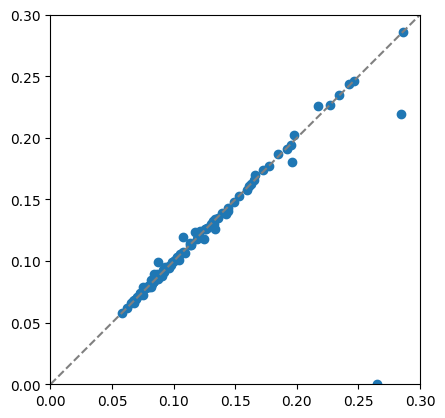

In [ ]:
def exact_elk(mu1: Tensor, sigma1: Tensor, mu2: Tensor, sigma2: Tensor) -> Tensor:
    """Implements a Monte Carlo estimator for the Expected Likelihood Kernel.
    For each

    Args:
        mu1, sigma1, mu2, sigma2: Float tensors of shape (n,) where the ELK is calculated
            for normals with  the corresponding means and standard deviations, resulting in
            n ELKs.

    Returns:
        A float tensor of shape (n,), containing the exact ELKs for normals with the
        corresponding means and standard deviations.

    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    sigma1_elk_sqr = 1/(1/sigma1**2 + 1/sigma2**2)
    mu1_elk = (mu1 * (1/sigma1**2) + mu2 * (1/sigma2**2))*sigma1_elk_sqr

    elk = 1/(np.sqrt(2 * np.pi)) * (torch.sqrt(sigma1_elk_sqr))/(sigma1 * sigma2) * torch.exp(
        -1/2 * (mu1**2 * 1/sigma1**2 + mu2**2 * 1/sigma2**2 - mu1_elk**2 * 1/sigma1_elk_sqr)
    )

    #### >>>> END OF YOUR SOLUTION <<<<
    return elk


def plot_comparison(n: int = 100) -> None:
    """Calculates the exact and approximate ELK for n pairs of normal distributions with
    different parameters. Then plots the exact vs. approximate results in a scatterplot.

    Args:
        n: Number of pairs of distributions.

    """
    # Generate some random parameters for our distributions
    mu1s = torch.zeros(n).uniform_()
    mu2s = torch.zeros(n).uniform_()
    sigma1s = torch.zeros(n).uniform_() * 5
    sigma2s = torch.zeros(n).uniform_() * 5

    #### >>>> PUT YOUR SOLUTION HERE <<<<
    # Calculate exact and approx ELK for each entry in (mu1s, sigma1s) vs (mu2s, sigma2s)
    exact = exact_elk(mu1s,sigma1s,mu2s,sigma2s)
    approx = mc_elk(mu1s,sigma1s,mu2s,sigma2s)
    #### >>>> END OF YOUR SOLUTION <<<<

    # Plot
    plt.plot([0, 1], [0, 1], color="grey", linestyle="dashed")
    plt.scatter(exact, approx)
    # You will probably run into numerical issues when using the non-logarithmed ELK for
    # high values
    plt.xlim(0, 0.3)
    plt.ylim(0, 0.3)
    plt.gca().set_aspect("equal")


plot_comparison()

## 3.3 Large Language Models and Uncertainty (12 points)

In this exercise, we will use the already familiar HuggingFace interface to inject uncertainty into LLMs and evaluate their calibration.

### 3.3.1 Text Generation (8 points)

Let's first load `GPT-2`, a fairly small autoregressive model we will work with for the first part of the exercise.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

... but how can we represent uncertainty for free in an LLM? The simplest and cheapest approximate model posterior is using MC dropout to obtain several models. We use this solely for simplicity: there are much more sophisticated model posteriors (such as [HET-XL](https://arxiv.org/abs/2301.12860) or [SNGP](https://arxiv.org/abs/2006.10108)) out there.

Complete the implementation of the function `predict_with_uncertainty` that returns the epistemic, aleatoric, and predictive uncertainty per each token. In formulas, for a token $x$ and models $f_1, \dots, f_M$ sampled from the dropout posterior,
$$
\begin{align*}
\text{EU}(x) &= \text{JSD}_{f_1, \dots, f_M}(x) = \mathbb{H}\left(\frac{1}{M}\sum_{i=1}^M f_i(x)\right) - \frac{1}{M}\sum_{i=1}^M \mathbb{H}\left(f_i(x)\right)\\
\text{AU}(x) &= \frac{1}{M}\sum_{i=1}^M \mathbb{H}\left(f_i(x)\right)\\
\text{PU}(x) &= \mathbb{H}\left(\frac{1}{M}\sum_{i=1}^M f_i(x)\right).
\end{align*}
$$
With this setup, it trivially holds that $\text{PU}(x) = \text{EU}(x) + \text{AU}(x)$. Take a moment to understand why (1) $\text{EU}(x)$ measures model disagreement, (2) $\text{AU}(x)$ approximates the stochasticity of the generative process, and $\text{PU}(x)$ contains both previous sources of uncertainty. If you feel convinced and find the metrics plausible, let's proceed.

*Hint: It is often useful to think about extreme scenarios: What is the highest possible $\text{EU}(x)$? How do the models behave in that case? What happens to $\text{PU}(x)$ when the aleatoric uncertainty is high but the epistemic uncertainty is low? What happens in the opposite case?*

*Question to the curious reader: Is $\text{PU}(x)$ connected to the notion of correctness that was introduced in the lecture? Your findings might point you to two separate interpretations of the predictive uncertainty.*

In [ ]:
# Function to get model predictions with uncertainties
@torch.no_grad()
def predict_with_uncertainty(model, text, n_samples=50):
    model.eval()
    enable_dropout(model)
    logits_list = []

    # Get multiple predictions using dropout
    for _ in range(n_samples):
        inputs = tokenizer(text, return_tensors="pt").to(device)
        logits = model(**inputs).logits
        logits_list.append(logits)

    #### >>>> PUT YOUR SOLUTION HERE <<<<
    logits_tensor = torch.stack(logits_list)
    probs = torch.softmax(logits_tensor, dim=-1)
    au_per_token = (1/n_samples) * torch.sum(torch.sum(-probs * torch.log(probs), axis=-1),axis=0) #
    sum_probs = torch.mean(probs, axis=0)
    pu_per_token = torch.sum(-sum_probs * torch.log(sum_probs),axis=-1)

    pu_per_token = pu_per_token.reshape(-1)
    au_per_token = au_per_token.reshape(-1)
    eu_per_token = pu_per_token - au_per_token

    # Implement the above formula for PU(x) and AU(x).
    # You get EU(x) trivially from these.
    # Don't aggregate the uncertainties over the tokens.
    # You should construct normalized probabilities.
    #### >>>> END OF YOUR SOLUTION <<<<

    return eu_per_token, au_per_token, pu_per_token

Now we have a tool to obtain token-wise uncertainties. Below, we provide a function to visualize the epistemic and aleatoric uncertainties. (Predictive uncertainty is left out, as it is just the sum of the previous two following the above definition.)

In [ ]:
def visualize_uncertainty(sentence, epistemic, aleatoric):
    # Tokenize the sentence to obtain individual words
    epistemic = epistemic.cpu()
    aleatoric = aleatoric.cpu()
    tokens = tokenizer.tokenize(sentence)

    # Create a bar plot
    x = np.arange(len(tokens))
    width = 0.35

    fig, ax = plt.subplots()

    rects1 = ax.bar(
        x - width / 2, epistemic, width, label="Epistemic Uncertainty", alpha=0.8
    )
    rects2 = ax.bar(
        x + width / 2, aleatoric, width, label="Aleatoric Uncertainty", alpha=0.8
    )

    ax.set_xlabel("Tokens")
    ax.set_ylabel("Uncertainty")
    ax.set_title("Uncertainties per token in the input sentence")
    ax.set_xticks(x)
    ax.set_xticklabels(tokens, rotation=45, ha="right")
    ax.legend()

    # Function to auto label the bars with their height values
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height:.2f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 1),
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

Now it's your turn. Experiment with the aleatoric and epistemic uncertainties and write a report in which you address the following points. You can be brief.
- How do these behave on "strange" sentences? Based on your intuition of what kind of texts GPT-2 was trained on, what sentences would you consider out-of-distribution?
- Do you see a tendency of how the token index affects the associated uncertainties?
- Are the magnitudes of the two uncertainty sources comparable?
- How stable are the uncertainty values across different runs of the same cell?
- Think of a simple, factually correct sentence. Try to modify a single word to make a completely nonsensical sentence. Do you see a change in the uncertainties between the two sentences? Are these changes stable w.r.t. stochasticity?

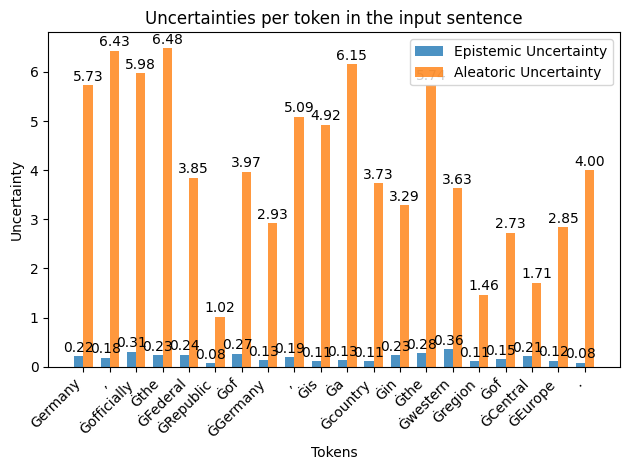

Average Epistemic Uncertainty: 0.1871
Average Aleatoric Uncertainty: 4.0844


In [ ]:
# Test on ambiguous sentences, incorrect sentences, etc.
#### >>>> PUT YOUR SOLUTION HERE <<<<
sentence = "Germany, officially the Federal Republic of Germany, is a country in the western region of Central Europe."
#### >>>> END OF YOUR SOLUTION <<<<
epistemic_uncertainty, aleatoric_uncertainty, _ = predict_with_uncertainty(
    model, sentence
)

visualize_uncertainty(sentence, epistemic_uncertainty, aleatoric_uncertainty)
print(f"Average Epistemic Uncertainty: {epistemic_uncertainty.mean().item():.4f}")
print(f"Average Aleatoric Uncertainty: {aleatoric_uncertainty.mean().item():.4f}")

1. There is a high chance that any information that is recent is unknown to GPT-2, such as a new developed algorithms. Also the noisy and corrupted sentences can also be regarded as OOD.
  - The sentence `"TübingenisabeatifulcitylocatedinGermany."` outputs $EU = 0.29$ and $AU = 6.23$ where as `"Tübingen is a beatiful city located in Germany."` outputs $EU=0.24$ and $AU = 4.91$.

  - Not finished sentences, such as `"Tübingen is a beatiful city located in` shows rather high uncertainity $EU = 0.26$ and $AU = 5.15$, one possible explanation to this observation is the model is not certain about how the sentence will end as there might be a several answers (Europe, Germany, Baden
   Württemberg).

2. As the token indices increases, there is a tendency that aleatoric and epistemic uncertainities to be reduced. However for longer sentences, this trend is less observable.
  - For the sentence `Brooklyn Nine-Nine is an American police procedural comedy television series that aired on Fox`, both aleatoric and epistemic uncertainity decreases as the token index increases (at first, model does not know how the sentence will be structured so this is expected)
  - For the sentence `Marvel Comics is an American comic book publisher and the property of The Walt Disney Company since December 31, 2009, and a subsidiary of Disney Publishing Worldwide since March 2023`, since there are actually two sentences connected with `and`, the uncertainities both increase after this keyword; but the uncertainities decreases again until the end of the sentence.

3. Magnitudes are not comparable. Aleatoric uncertainity seems to have a larger magnitude compared to the epistemic uncertainity. One possible explanation is epistemic uncertainity expected to decrease with more training data whereas aleatoric uncertainity is within the data itself and hence, irreducible. The reason can also be explained that many of the tokens can appear differently with the combination of others such as `Strawberries are ...` can end with either of the`red` or `berries`, which means there are multiple plausiable answers; hence, aleatoric uncertainity.

4. Since each dropout corresponds for a different neural network instance, we expect calculated uncertainities to change with each run. However the variance of the uncertainity is low. (For 50 runs on a specific sentence, $EU = 0.241 \pm 0.01  $ and $AU = 5.12 \pm 0.04$) where the values are reported as $\mu \pm \sigma$


5. Let us use the same sentence, `"Tübingen is a beatiful city located in Germany."`
  - Replace the word `city` with `vegetable` increases $EU$ from $0.2458 \pm 0.007$ to $0.2628 \pm 0.01$ and $AU$ from $4.94 \pm 0.027$ to $5.017 \pm 0.034$ calculated over $10$ runs. This is expected since this sentence is non-sense.
  - Replace the word `city` with `c1ty` increases $EU$ from $0.2458 \pm 0.007$ to $0.275 \pm 0.008$ and $AU$ from $4.94 \pm 0.027$ to $5.36 \pm 0.050$ calculated over 10 runs. One reason is $1$ is counted as a seperate token, which increases the uncertanities for both concurrent tokens as the sentence now became corrupted.
  - The token `is` is an important keyword; even changing this token to `it` increases the $AU = 5.16$ and $EU = 0.28$.

This result shows that meaningless sentences and factually ambigious and non-sensical (Tübingen being a vegetable) increases the uncertainity. However the token that is changed is also important.


Let's spend a bit more time on trying to detect factual errors in the input using uncertainty. First, complete the code below using the function `roc_auroc_score`. Check where it's imported from and try to understand its inputs. Then, run the cell and observe the results. Which type of uncertainty is the most predictive of correctness? Now, run the cell multiple times. Are the results stable over stochasticity? Would you trust a system that tries to detect falsehood using some of these uncertainties?

*Note: While the results might be interesting on their own, consider the fact that the MC dropout is a simple approximate posterior and the chosen model is also far from being state-of-the-art.*

In [ ]:
sentences = [
    "Donald Trump is a British songwriter.",
    "Donald Trump is an American politician and businessman.",
    "Albert Einstein is an Indian physicist.",
    "Edward Teller is a Hungarian physicist.",
    "The first World War was in the 14th century.",
    "The Declaration of Independence was signed in 1776.",
    "John von Neumann has been to Los Alamos.",
    "The Sun has an extremely cold temperature.",
    "Germany is a country in America.",
    "Michael Jackson was an extremely popular black singer.",
    # Feel free to extend/change this list if you get more interesting results that way.
]
correctness = np.array([0, 1, 0, 1, 0, 1, 1, 0, 0, 1])

eus = []
aus = []
pus = []
for sentence in sentences:
    (
        epistemic_uncertainty,
        aleatoric_uncertainty,
        predictive_uncertainty,
    ) = predict_with_uncertainty(model, sentence)
    eu = epistemic_uncertainty.mean().item()
    au = aleatoric_uncertainty.mean().item()
    pu = predictive_uncertainty.mean().item()
    eus.append(eu)
    aus.append(au)
    pus.append(pu)

eus = np.array(eus)
aus = np.array(aus)
pus = np.array(pus)
#### >>>> PUT YOUR SOLUTION HERE <<<<
print(f"ROC AUC of EU: {roc_auc_score(correctness,-eus):.5f}")

print(f"ROC AUC of AU: {roc_auc_score(correctness,-aus):.5f}")

print(f"ROC AUC of PU: {roc_auc_score(correctness,-pus):.5f}")

# Print the AUROC scores of the negative epistemic, aleatoric, and predictive uncertainties
# against the correctness of prediction.
#### >>>> END OF YOUR SOLUTION <<<<

ROC AUC of EU: 0.80000
ROC AUC of AU: 0.64000
ROC AUC of PU: 0.64000


*Which type of uncertainty is the most predictive of correctness?*
 - ROC AUC of the epistemic uncertainity is *generally* higher than the aleaotoric or predictive uncertainity.

*Now, run the cell multiple times. Are the results stable over stochasticity?*
- The results are not stable as each run, we have encountered with different ROC AUC scores. It is also important to note that although many cases favoured epistemic uncertainity, some of the cases were in favour of AU/PU.

*Would you trust a system that tries to detect falsehood using some of these uncertainties?*
- Due to unstability of the ROC AUC scores, I would not trust this system for the classification of a correct sentence from a wrong sentence. Also, there is a high chance that the model has a limited knowledge for the events happened after its cut-off date and hence, these sentences would have a higher epistemic uncertainity. For the sensitive topics, factually correct sentence can have a high aleatoric uncertainity.

### 3.3.2 Named Entity Recognition (4 points)

Let's turn to Named Entity Recognition. Don't worry, this part doesn't need new ideas. We'll use our uncertainty estimators from above in a different setting: Named Entity Recognition, where we aim to detect different types of named entities in the input (such as people, geographical locations, institutions, or brands).

In [ ]:
# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


What uncertainties do we obtain for the individual tokens in a toy example?

In [ ]:
text = "HuggingFace is a company based in New York."
tokens = tokenizer.tokenize(text)

eu, au, _ = predict_with_uncertainty(model, text)

for token, epistemic, aleatoric in zip(tokens, eu, au):
    print(f"{token}\t\tEpistemic: {epistemic:.4f}\tAleatoric: {aleatoric:.4f}")

Hu		Epistemic: 0.0005	Aleatoric: 0.0183
##gging		Epistemic: 0.1385	Aleatoric: 0.6670
##F		Epistemic: 0.1941	Aleatoric: 0.9066
##ace		Epistemic: 0.0139	Aleatoric: 0.1692
is		Epistemic: 0.0553	Aleatoric: 0.4758
a		Epistemic: 0.0000	Aleatoric: 0.0018
company		Epistemic: 0.0000	Aleatoric: 0.0014
based		Epistemic: 0.0000	Aleatoric: 0.0024
in		Epistemic: 0.0000	Aleatoric: 0.0015
New		Epistemic: 0.0000	Aleatoric: 0.0015
York		Epistemic: 0.0006	Aleatoric: 0.0203
.		Epistemic: 0.0001	Aleatoric: 0.0121


Now, we can check how well the model's correctness correlates with our uncertainty estimates on the `conll2003` dataset. First, we need some boilerplate code to align the dataset labels with the tokens. This is needed because the tokenizer for our model is a subword tokenizer whereas the dataset labels correspond to words. This means that our model predicts a named entity class for each subword token, but the labels for the sentences are for individual words.

You don't need to understand the boilerplate code, but feel free to explore it if you feel confused by the subsequent code cell.

In [ ]:
# Load the dataset
raw_datasets = load_dataset("conll2003")


# Function to align labels with tokens
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels


# Function to tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs


# Tokenize and align the dataset
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Below, we evaluate our uncertainty estimators on how well they can predict the correctness of our model's per-token classification. Which uncertainty metric results in the highest AUROC? How stable are these AUROC results with the stochasticity in the model posterior? Would you trust these estimates compared to the GPT-2 ones?

In [ ]:
def evaluate_aurocs(tokenized_datasets, model, tokenizer):
    # Initial lists to store results
    correctness = []
    eus = []
    aus = []
    pus = []

    # Evaluate on 16 test examples
    # These are 16 test samples that might actually appear in natural language
    for idx in tqdm(range(300, 317)):
        sample = tokenized_datasets["test"][idx]

        # Get the text sentence from token IDs
        sentence = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)

        # Get uncertainties
        #### >>>> PUT YOUR SOLUTION HERE <<<<
        eu, au, pu =  predict_with_uncertainty(model, sentence)
        #### >>>> END OF YOUR SOLUTION <<<<

        # Get model's predictions
        inputs = tokenizer(sentence, return_tensors="pt").to(device)
        logits = model(**inputs).logits
        predictions = torch.argmax(logits, dim=-1)[0].tolist()

        # Check correctness and store results into
        # `correctness`, `eus`, `aus`, and `pus`
        for true_label, pred, eu_val, au_val, pu_val in zip(
            sample["labels"], predictions, eu, au, pu
        ):
            if true_label != -100:  # Exclude special tokens
                #### >>>> PUT YOUR SOLUTION HERE <<<<
                correctness.append(1 if true_label == pred else 0)
                eus.append(eu_val.cpu())
                aus.append(au_val.cpu())
                pus.append(pu_val.cpu())
                #### >>>> END OF YOUR SOLUTION <<<<

    # Compute AUROC
    epistemic_auroc = roc_auc_score(correctness, -np.array(eus))
    aleatoric_auroc = roc_auc_score(correctness, -np.array(aus))
    predictive_auroc = roc_auc_score(correctness, -np.array(pus))

    print("\nAccuracy:", sum(map(int, correctness)) / len(correctness))
    print("Epistemic AUROC:", epistemic_auroc)
    print("Aleatoric AUROC:", aleatoric_auroc)
    print("Predictive AUROC:", predictive_auroc)

    return correctness, eus, aus, pus

correctness, eus, aus, pus = evaluate_aurocs(tokenized_datasets, model, tokenizer)

100%|██████████| 17/17 [00:12<00:00,  1.36it/s]


Accuracy: 0.8418803418803419
Epistemic AUROC: 0.9758883248730964
Aleatoric AUROC: 0.9817876251886404
Predictive AUROC: 0.9816161339003978


 *Which uncertainty metric results in the highest AUROC?*
  - The metric that result in highest AUROC is the **Aleatoric uncertainity**.



 *How stable are these AUROC results with the stochasticity in the model posterior?*
  - The stablity of the AUROC results is much more higher compared to the previous case. Within multiple runs, only minor amounts of differences were present in the estimated uncertainities and it did not change the uncertainity with highest AUROC.
  

 *Would you trust these estimates compared to the GPT-2 ones?*
  - The estimates were much more trustful compared to GPT-2 as both the AUROC and their stability is better. In terms of trusthworthiness, due to the higher AUROC scores, this system is more trustful. However similarly, recent informations compared to cut-off date and sensitive topics are type of sentences that the model will have a high uncertainity even for the factually correct sentences.


Let's verify our results visually as well. Make a plot containing the epistemic uncertainties separately for correct and incorrect tokens, and see whether you find linear separability. Choose your plot type and limits carefully to convey your message. Interpret your results.

Accuracy of the threshold: 0.953


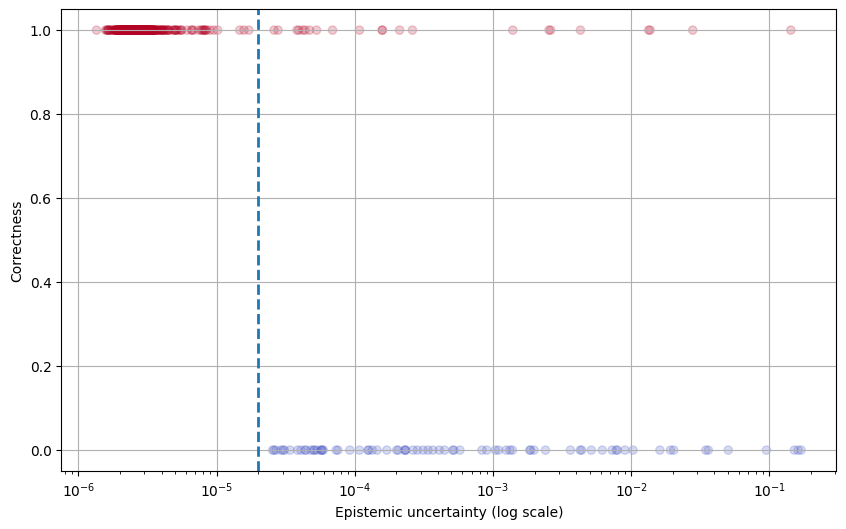

In [ ]:
plt.figure(figsize=(10, 6))
#### >>>> PUT YOUR SOLUTION HERE <<<<
THRSHOLD = 2*10**(-5)
plt.scatter(x=eus, y=correctness, alpha=0.2, c=correctness, cmap='coolwarm')  # Plotting the scatter plot
plt.xscale("log")  # Setting x-axis to logarithmic scale
plt.grid()  # Adding a grid
plt.xlabel("Epistemic uncertainty (log scale)")  # X-axis label
plt.ylabel("Correctness")  # Y-axis label
plt.axvline(x = THRSHOLD, lw=2, linestyle='--')

eus_np = np.array(eus)
correctness_np = np.array(correctness)
eus_zeros = np.zeros_like(eus_np,dtype=np.uint8)
eus_zeros[eus_np < THRSHOLD] = 1

print(f"Accuracy of the threshold: {np.sum(correctness_np == eus_zeros)/eus_zeros.shape[0]:.3f}")
#### >>>> END OF YOUR SOLUTION <<<<
plt.show()

The plot above shows that the threshold $2\cdot10^{-5}$ is a nice way to seperate true and false value with each other. Many of the factually correct sentences has epistemic uncertainity that is very close to $0$ where as epistemic uncertainity of the wrong sentences are higher. This is expected since sentences that are factually accurate tend to align closely with the information the model was exposed to during training, particularly if the training dataset was extensive and encompassed a broad spectrum of accurate data. Consequently, the model is expected to exhibit greater confidence (manifested as reduced epistemic uncertainty) in these sentences, given that they are well-represented within the scope of its training data.


# **4. Relationships Between Predictive, Aleatoric, and Epistemic Uncertainty (15 points)**
**Recommended start: 22.01.2024**

In the last exercise, we will relate different sources of uncertainty by exact formulas. We will gain an understanding for the relationship of predictive, aleatoric, and epistemic uncertainty through various uncertainty decompositions. Note that "the" uncertainty decomposition doesn't exist. There are many sensible formulations; what performs best for your specific use case should be given preference.

## 4.1 A Risk-based Predictive Uncertainty Decomposition (10 points)

### 4.1.1 Regression (5 points)

Consider a regression problem with label space $\mathcal{Y} = \mathbb{R}$ and pointwise generative process $P(Y \mid X = x) = \mathcal{N}\left(Y; \mu(x), \sigma^2(x)\right)$. We choose the squared loss $\ell(y, a) = (y - a)^2$ where $a \in \mathcal{A} = \mathbb{R}$ is an element of the action space.

(a) Show that the pointwise risk, defined as $R(f, x) = \mathbb{E}_{P(Y \mid X = x)}\left[\ell(Y, f(x))\right]$ is equal to $\sigma^2(x) + (f(x) - \mu(x))^2$. Does this value capture our desiderata from predictive uncertainty? Argue based on intuitive definitions from the lecture.

**(a)**

\begin{align*}
R(f, x) &= \mathbb{E}_{P(Y \mid X = x)}\left[(Y - f(x))^2\right] \\
&= \int_{-\infty}^{\infty} (y - f(x))^2 \frac{1}{\sqrt{2\pi\sigma^2(x)}} e^{-\frac{(y - \mu(x))^2}{2\sigma^2(x)}} \,dy
\end{align*}

Make the following substitution:
$$
z = \frac{y - \mu(x)}{\sigma(x)} \\
dz = \frac{dy}{\sigma(x)}
$$

Then the resulting expression is as follows:
\begin{align*}
&= \int_{-\infty}^{\infty} \frac{(z \sigma(x) + \mu(x) - f(x))^2}{\sqrt{2\pi\sigma^2(x)}} e^{-\frac{z^2}{2}} \,\sigma(x) dz \\
&= \int_{-\infty}^{\infty} \frac{e^{-\frac{z^2}{2}}}{\sqrt{2 \pi}}  ( \mu(x) - f(x))^2 dz  
 \;\;  + \int_{-\infty}^{\infty}  \frac{e^{-\frac{z^2}{2}}}{\sqrt{2 \pi}} z^2  \sigma^2(x) dz \;\; + \int_{-\infty}^{\infty}  \frac{e^{-\frac{z^2}{2}}}{\sqrt{2 \pi}} 2 z \sigma(x) (\mu(x) - f(x)) dz \\
\end{align*}

Here, in order to proceed, we have to make couple of observations: If $Z \sim \mathcal{N}(0, 1)$, then $\mathbb{E}(Z) = 0$ and $\mathbb{E}(Z^2) = \text{Var}(Z) + \mathbb{E}^2(Z) = 1 + 0 = 1$. Therefore, it follows that:

\begin{align*}
 R(f, x) &=   (f(x) - \mu(x))^2  + \sigma^2(x)
 \end{align*}

Predictive uncertainty refers to the extent of uncertainty or lack of confidence exhibited by a machine learning model when making predictions for a given input. Lower values of $R(f, x)$ indicate that predictions for each input remain close to the mean of the true distribution $\mu(x)$, indicating small variance and, consequently, high confidence in predictions. Conversely, higher $R(f, x)$ values suggest that predictions for each input exhibit greater variance, with non-zero $(f(x) - \mu(x))$ terms occurring frequently. Therefore, assessing $R(f, x)$ allows us to comment on predictive uncertainty, as it effectively captures our desired characteristics in addressing predictive uncertainty.

$R(f, x)$

(b) What is the pointwise Bayes predictor $f^*(x) = \arg\min_{a \in \mathcal{A}} \mathbb{E}_{P(Y \mid X = x)}\left[\ell(Y, a)\right]$?

\begin{align*}
 \arg\min_{a \in \mathcal{A}} \mathbb{E}_{P(Y \mid X = x)}\left[\ell(Y, a)\right] &= \arg\min_{a \in \mathcal{A}} \left[\sigma^2(x) + (a - \mu(x))^2\right]
 \end{align*}
 Taking the derivative of the right hand side:
 \begin{align*}
 2 (a - \mu(x)) &= 0  → a = \mu(x) \\
f^*(x) = \mu(x)
  \end{align*}

  We can verify that the stationary point is the global minimum by taking the second derivative:
 \begin{align*}
 \frac{\partial^2 R}{\partial a^2} = 2 \geq 0  \;\; → \text{$R$ is convex in $a$}
 \end{align*}


(c) Argue if $R(f^*, x)$ is a reasonable aleatoric uncertainty metric based on the informal definition from the lecture.

The equation $R(f^*, x) = \sigma^2(x)$ represents the variance of the distribution $P(Y \mid X = x)$. To put it simply: when we randomly pick values of $y$ from $P(Y | X = x)$, we consider the aleatoric uncertainty to be high if these values are spread out. Conversely, if most of our $y$ values fall within a specific and narrow range, we describe it as having low aleatoric uncertainty. Therefore, intuitively, the variance of the ground truth probability distribution serves as a reasonable metric for aleatoric uncertainty.


### 4.1.2 Classification (5 points)

Consider a classification problem with label space $\mathcal{Y} = \{1, \dots, K\}$ and pointwise generative process $P(Y \mid X = x) = \operatorname{Cat}(\mu(x))$. We choose the negative log-likelihood (NLL) loss $\ell(y, a) = -\log a_y$ where $a \in \mathcal{A} = \Delta^K$ is an element of the action space, i.e., the $K-1$-dimensional probability simplex.

(a) Show that the pointwise risk is equal to $\mathbb{H}\left(\mu(x), f(x)\right)$. Does this value capture our desiderata from predictive uncertainty?

**Answer**: $\mu(x) = \{\mu_1(x), \mu_2(x), ..., \mu_K(x)\}$ is a $K$-dimensional vector representing the probabilities assigned to each class for the input $x$. Cross entropy $\mathbb{H}\left(\mu(x), f(x)\right)$ is defined as follows:

\begin{align*}
\mathbb{H}\left(\mu(x), f(x)\right) = - \sum_{y \in \mathcal{Y}} \mu_y(x)\log f_y(x)
\end{align*}

Now, let's calculate the pointwise risk:
\begin{align*}
P(Y  = y \mid X = x) &= \operatorname{Cat}(\mu(x)) = \mu_y(x)\\
R(f, x) &= \mathbb{E}_{P(Y \mid X = x)}\left[-\log f_Y(x)\right] \\
&= - \sum_{y \in \mathcal{Y}} \mu_y(x)  \log f_y(x) \\
\end{align*}

Hence, the pointwise risk equals $\mathbb{H}(\mu(x), f(x))$, which represents the cross entropy between the true distribution and the predicted distribution. Cross entropy is a proper scoring rule for aleatoric uncertainty (below we showed that the true distribution maximizes the expected scoring rule). As stated in (3), any proper scoring rule for aleatoric uncertainty is applicable to assessing the correctness of predictions. Therefore $\mathbb{H}(\mu(x), f(x))$ produces the desiderata for predictice uncertainty as well. Intuitively, minimizing the expected value of the cross entropy requires prediction distribution to be similar to GT probability distribution - achieving higher predictive certainty using the max-prob classification $c(x) =\text{max}_k f_k(x)$.


[3]: Mucsányi, B., Kirchhof, M., Nguyen, E., Rubinstein, A., & Oh, S. J. (2023). Trustworthy Machine Learning (p. 303). Retrieved from arXiv preprint server (eprint 2310.08215).


(b) What is the pointwise Bayes predictor?

\begin{align*}
f^*(x) = \arg\min_{a \in \mathcal{A}} \mathbb{E}_{P(Y \mid X = x)}\left[\ell(Y, a)\right] &= \arg\min_{a \in \mathcal{A}} \left[- \sum_{y \in \mathcal{Y}} \mu_y(x)  \log a_y  \right] \\
&= \arg\max_{a \in \mathcal{A}} \left[ \sum_{y \in \mathcal{Y}} \mu_y(x)  \log a_y  \right] \\
&= \arg\max_{a \in \mathcal{A}} \left[ \mu_1(x) \log a_1 + \mu_2(x) \log a_2 + ... + \mu_n(x) \log a_n  \right] \\
&= \arg\max_{a \in \mathcal{A}} \left[ \mu_1(x) \log a_1 + \mu_2(x) \log a_2 + ... + (1 - \mu_1(x) - ... - \mu_{n-1}(x))  \log (1- a_1 - ... - a_{n-1})  \right] \;\;\; \text{d.o.f = $n - 1$}\\
\end{align*}
Taking derivative with respect to each $a_i$:
\begin{align*}
\frac{\partial \; \mathbb{E}_{P(Y \mid X = x)}\left[\ell(Y, a)\right]}{\partial a_i} &= \frac{1}{a_i} \mu_i + \frac{-1}{1 - \sum_{j \neq i} a_j} \left( 1- \sum_{j \neq i} \mu_j \right) \\
&= \frac{\mu_i - \sum_{j \neq i} a_j \mu_i - a_i + \sum_{j \neq i} a_j \mu_i}{a_i (1 - \sum_{j \neq i} a_j)} \\
&= \frac{\mu_i - a_i}{a_i (1 - \sum_{j \neq i} a_j)}
\end{align*}

Derivative is equal to zero when $a_i = \mu_i$. To conclude that it is the minimum point, we have to check the second derivative:



\begin{align*}
\frac{\partial^2 \; \mathbb{E}_{P(Y \mid X = x)}\left[\ell(Y, a)\right]}{\partial a_i^2} &= \frac{- a_i [1 -  \sum_{j \neq i} a_j]  - [1 -  \sum_{j \neq i} a_j] (\mu_i - a_i)}{(a_i (1 - \sum_{j \neq i} a_j))^2}\\
&= \frac{- a_i  +  \sum_{j \neq i} a_ja_i  -\mu_i + a_i -  \sum_{j \neq i} a_j\mu_i - \sum_{j \neq i} a_j a_i}{(a_i (1 - \sum_{j \neq i} a_j))^2}\\
&= \frac{ \sum_{j \neq i} a_ja_i  -\mu_i  -  \sum_{j \neq i} a_j\mu_i - \sum_{j \neq i} a_j a_i}{(a_i (1 - \sum_{j \neq i} a_j))^2}\\
&= \frac{  -\mu_i  -  \sum_{j \neq i} a_j\mu_i }{(a_i (1 - \sum_{j \neq i} a_j))^2}\\
&= \frac{  -\mu_i( 1 +   \sum_{j \neq i} a_j)}{(a_i (1 - \sum_{j \neq i} a_j))^2}\\
\end{align*}

Denominator is non-negative since it is squared. Nominator is negative since $\forall i \; \mu_i, a_i \geq 0$. Since the second derivative is always non-positive, we can conclude that $f^*(x) = \mu(x)$ is the global maximum.  Here, if $\mu_i = 0$, then the second derivative is zero, however it doesn't conflict with our conclusion since it cannot be positive at any point (inflection point).

(c) Argue if $R(f^*, x)$ is a reasonable aleatoric uncertainty metric.

$R(f^∗,x)  = H(\mu(x))$. Aleatoric confidence can be given as the entropy of the predicted distribution (which is equal to the actual distribution in our case). High entropy means there's a lot of uncertainty, like when you see equal chances for different labels in a user study with a confusing image. Low entropy indicates low aleatoric uncertainty. To conclude, yes, we can use $R(f^∗,x)$ as an aleatoric uncertainty metric.


## 4.2 An Information-Theoretical Predictive Uncertainty Decomposition (5 points)

Let the distribution $P(Y \mid x, \omega)$ denote model $\omega$s prediction for input $x$ (e.g., by considering the model's softmax output). Further, let $P(Y \mid x, \mathcal{D}) := \int_\Omega P(Y \mid x, \omega) dP(\omega \mid \mathcal{D})$ be the so-called predictive distribution. Let $\mathbb{I}(Y; \omega \mid x, \mathcal{D}) := D_\text{KL}\left(P(Y, \omega \mid x, \mathcal{D})\ \Vert\ P(Y \mid x)P(\omega \mid \mathcal{D})\right)$ be the mutual information of the variables $Y \mid x$ and $\omega \mid \mathcal{D}$. *Note: the decomposition we discussed for the NLP models has close ties with this one.*

(a) Try to gain an intuition for the mutual information. What is its minimizer and for what $P(Y, \omega \mid x, \mathcal{D})$ does it happen?

**Answer**: Mutual information is given by the KL-Divergence. If $P$ and $Q$ are identical, $Q$ doesn't diverge at all from $P$ and the KL-divergence is accordingly zero. So, $\mathbb{I}(Y; \omega \mid x, \mathcal{D})$ is minimized (KL-divergence cannot be less than zero) when $P(Y, \omega \mid x, \mathcal{D}) = P(Y \mid x)P(\omega \mid \mathcal{D})$. This suggests that the mutual information is minimized when knowing the value of $Y$ given $X$ doesn't give any information as to the value of $\omega$ given $\mathcal{D}$. Intuitively, mutual information is minimized when the epistemic uncertainty, that is the dependence between $P(Y \mid x)$ and $P(\omega \mid \mathcal{D})$ is minimized.




(b) Show that $$\mathbb{H}_{P(Y \mid x, \mathcal{D})}(Y) = \mathbb{I}(Y; \omega \mid x, \mathcal{D}) + \mathbb{E}_{P(\omega \mid \mathcal{D})}\left[\mathbb{H}_{P(Y \mid x, \omega)}(Y)\right].$$

**Answer**

Before starting, let's convince ourselves that the following facts are true:

1. $P(Y \mid \omega, x, \mathcal{D}) = P(Y \mid x, \omega) \rightarrow Y \perp \!\!\! \perp \mathcal{D} \mid \omega $
2. $P(\omega \mid x, \mathcal{D}) = P(\omega \mid \mathcal{D}) \;\;\;\;\;\;\;\;  \rightarrow \omega \perp \!\!\! \perp x $

First statement states that prediction $Y$ is independent from training data $\mathcal{D}$ given the model $w$. It's because prediction is simply based on the input $x$ and model $w$ (parameters) when they are provided. Model parameters are dependent on the training data $\mathcal{D}$ - which makes $Y$ dependent on $\mathcal{D}$ if $w$ is not provided. You can think of it as a Bayes Network where the information about $w$ cuts the connection between $Y$ and $\mathcal{D}$.

Second statement states that $w$ and $x$ are independent, which is easy to see since model parameters $w$ are not dependent on the test input $x$. (However they would be dependent given $Y$, think of it as a Bayes network where $x$ and $w$ points out to $Y$)

After discussing these two observations, let's proceed with algebraic manipulations:

<style>
r { color: Red }
o { color: Orange }
g { color: Green }
</style>

\begin{align*}
\mathbb{H}_{P(Y \mid x, \mathcal{D})}(Y) - \mathbb{E}_{P(\omega \mid \mathcal{D})}\left[\mathbb{H}_{P(Y \mid x, \omega)}(Y)\right] &\stackrel{?}{=} \mathbb{I}(Y; \omega \mid x, \mathcal{D}) \\
-\int_{\Omega_y} P(Y \mid x, \mathcal{D}) \log(P(Y \mid x, \mathcal{D})) dy  + \int_{\Omega_y}\int_{\Omega_\omega} P(Y \mid x, \omega) \log(P(Y \mid x, \omega)) P(\omega \mid \mathcal{D}) d\omega dy &\stackrel{?}{=} \int_{\Omega_y}\int_{\Omega_\omega} P(Y, \omega \mid x, \mathcal{D}) \log \left[ \frac{P(Y, \omega \mid X, \mathcal{D})} {P(Y \mid x, \mathcal{D}) P(\omega \mid x, \mathcal{D})}\right] d\omega dy \\
-\int_{\Omega_y} \int_{\Omega_\omega} P(Y \mid x, \omega) \log(P(Y \mid x, \mathcal{D})) d\omega dy  + \int_{\Omega_y}\int_{\Omega_\omega} P(Y \mid x, \omega) \log(P(Y \mid x, \omega)) P(\omega \mid \mathcal{D}) d\omega dy &\stackrel{?}{=} \int_{\Omega_y}\int_{\Omega_\omega} P(Y, \omega \mid x, \mathcal{D}) \log \left[ \frac{P(Y, \omega \mid x, \mathcal{D})} {P(Y \mid x, \mathcal{D}) P(\omega \mid x, \mathcal{D})}\right] d\omega dy \\
  \int_{\Omega_y}\int_{\Omega_\omega} P(Y \mid x, \omega) P(\omega \mid \mathcal{D}) \log( \frac{P(Y \mid x, \omega)}{P(Y \mid x, \mathcal{D})}) d\omega dy &\stackrel{?}{=} \int_{\Omega_y}\int_{\Omega_\omega} P(Y, \omega \mid x, \mathcal{D}) \log \left[ \frac{P(Y, \omega \mid x, \mathcal{D})} {P(Y \mid x, \mathcal{D}) P(\omega \mid x, \mathcal{D})}\right] d\omega dy \\
\end{align*}


Now, we should demonstrate the equivalence of these two equations by establishing that the terms with and without logarithms are equal to their respective counterparts on the right-hand side.
1. $P(Y, \omega \mid x, \mathcal{D}) = P(Y \mid x, \omega, \mathcal{D}) P(\omega \mid x, \mathcal{D})  =P(Y \mid x, \omega) P(\omega \mid \mathcal{D}) $
2. $\frac{P(Y, \omega \mid x, \mathcal{D})}{P(Y \mid x, \mathcal{D}) P(\omega \mid x, \mathcal{D})} = \frac{P(Y\mid x, \omega, \mathcal{D}) P(\omega \mid x, \mathcal{D})}{P(Y \mid x, \mathcal{D}) P(\omega \mid x, \mathcal{D})}  = \frac{P(Y\mid x, \omega)}{P(Y \mid x, \mathcal{D})} $  

Thus, we showed that two expressions are equal to each other.

(c) Based on your findings and the intuition from (a), what different sources of uncertainty do the individual components measure? Like in the previous sections, it suffices to argue based on informal desiderata from the lecture.

 $\mathbb{E}_{P(\omega \mid \mathcal{D})}\left[\mathbb{H}_{P(Y \mid x, \omega)}(Y)\right]$ calculates the expected entropy in the conditional probability $P(Y \mid x, \omega)$. It expresses
the uncertainty about $Y$ that would remain if the realization of $\omega$ were known. Therefore we can say that it measures the aleatoric uncertainty. Mutual information, as we discussed in the first part, gives information about the epistemic uncertainty.  $ \mathbb{H}_{P(Y \mid x, \mathcal{D})}(Y)$ is the entropy of the prediction distribution - therefore the predictive (or total) uncertainty. This decomposition is similar to what is suggested in the paper [Quantifying Aleatoric and Epistemic Uncertainty in Machine Learning: Are Conditional Entropy and Mutual Information Appropriate Measures?](https://arxiv.org/abs/2209.03302) (4). Although this kind of separation for the uncertainty measures is applicable, it is observed and empirically confirmed that these measures behave neither coherently nor always as expected.

[4]: Wimmer, L., Sale, Y., Hofman, P., Bischl, B., & Hüllermeier, E. (2023). Quantifying Aleatoric and Epistemic Uncertainty in Machine Learning: Are Conditional Entropy and Mutual Information Appropriate Measures? [Preprint]. arXiv. https://arxiv.org/abs/2209.03302

You did it! This was the last exercise of the course. I hope you had a great time! Best of luck on the exam!

Bálint

thanks!  